## step

1. load dataset
2. combine data
3. split data
4. transform and cocodataset
5. loader
6. pretrain model
7. train and mAP Evaluation
9. fine tune

final model retrain:
Step:load,split,delete, run all final model code

## Load data

In [1]:
!pip install roboflow

from roboflow import Roboflow

# Dataset 1 (Version 5)
rf = Roboflow(api_key="FiU3mGWvliwkxuEHra5I")
project = rf.workspace("intelligent-systems-group-8-2025").project("vehicle-license-plate-detection-zasj3")

version = project.version(5)
dataset = version.download("coco")

# Dataset 2 (Version 7)
version = project.version(7)
dataset = version.download("coco")

# Dataset 3 (Version 9)
version = project.version(9)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.4 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Vehicle-License-Plate-Detection-5 in coco:: 100%|██████████| 279/279 [00:00<00:00, 582.50it/s]


Extracting Dataset Version Zip to Vehicle-License-Plate-Detection-7 in coco:: 100%|██████████| 356/356 [00:00<00:00, 1037.79it/s]


Extracting Dataset Version Zip to Vehicle-License-Plate-Detection-9 in coco:: 100%|██████████| 838/838 [00:00<00:00, 898.53it/s]


In [2]:
import json
import os
import shutil

def merge_coco_datasets(json_paths, image_dirs, merged_dir):
    os.makedirs(os.path.join(merged_dir, "images"), exist_ok=True)

    merged = {
        "images": [],
        "annotations": [],
        "categories": None
    }

    img_id_offset = 0
    ann_id_offset = 0

    for json_path, img_dir in zip(json_paths, image_dirs):
        with open(json_path, "r") as f:
            data = json.load(f)

        if merged["categories"] is None:
            merged["categories"] = data["categories"]

        for img in data["images"]:
            img["id"] += img_id_offset
            merged["images"].append(img)
            shutil.copy2(os.path.join(img_dir, img["file_name"]),
                         os.path.join(merged_dir, "images", img["file_name"]))

        for ann in data["annotations"]:
            ann["id"] += ann_id_offset
            ann["image_id"] += img_id_offset
            merged["annotations"].append(ann)

        #1. ID偏移计算方式风险
        img_id_offset += len(data["images"])
        ann_id_offset += len(data["annotations"])

    merged_json_path = os.path.join(merged_dir, "merged_annotations.json")
    with open(merged_json_path, "w") as f:
        json.dump(merged, f)

    return merged_json_path


In [3]:
jsons = [
    "/content/Vehicle-License-Plate-Detection-5/train/_annotations.coco.json",
    "/content/Vehicle-License-Plate-Detection-7/train/_annotations.coco.json",
    "/content/Vehicle-License-Plate-Detection-9/train/_annotations.coco.json"
]
imgs = [
    "/content/Vehicle-License-Plate-Detection-5/train",
    "/content/Vehicle-License-Plate-Detection-7/train",
    "/content/Vehicle-License-Plate-Detection-9/train"
]

merged_dir = "/content/merged_dataset"
merged_json = merge_coco_datasets(jsons, imgs, merged_dir)


### Checking for information


In [54]:
import json
from collections import Counter

def print_coco_summary(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    print(f"\n📂 File: {json_path}")
    print(f"🖼️ Total images: {len(data['images'])}")
    print(f"📝 Total annotations: {len(data['annotations'])}")
    print(f"🏷️ Total categories: {len(data['categories'])}\n")

    # Print all categories
    print("📚 Categories:")
    for cat in data['categories']:
        print(f"  ID: {cat['id']:2} | Name: {cat['name']} | Supercategory: {cat['supercategory']}")

    # Count how many annotations use each category_id
    ann_counts = Counter([ann["category_id"] for ann in data["annotations"]])
    print("\n📊 Annotation Counts by Category ID:")
    for cat in data['categories']:
        cat_id = cat["id"]
        print(f"  ID: {cat_id} ({cat['name']}): {ann_counts.get(cat_id, 0)} annotations")

    # Print first 3 images
    print("\n🖼️ Sample Images (first 3):")
    for img in data['images'][:3]:
        print(f"  ID: {img['id']}, File: {img['file_name']}, Size: {img['width']}x{img['height']}")

    # Print first 3 annotations
    print("\n🔍 Sample Annotations (first 3):")
    for ann in data['annotations'][:3]:
        print(f"  ID: {ann['id']}, ImageID: {ann['image_id']}, CatID: {ann['category_id']}, BBox: {ann['bbox']}, Area: {ann['area']}, Crowd: {ann['iscrowd']}")

# List of JSON files to analyze
jsons = [
    "/content/Vehicle-License-Plate-Detection-5/train/_annotations.coco.json",
    "/content/Vehicle-License-Plate-Detection-7/train/_annotations.coco.json",
    "/content/Vehicle-License-Plate-Detection-9/train/_annotations.coco.json"
]

# Print summary for each JSON file
for json_file in jsons:
    print_coco_summary(json_file)
    print("\n" + "="*80 + "\n")  # Separator for better readability


📂 File: /content/Vehicle-License-Plate-Detection-5/train/_annotations.coco.json
🖼️ Total images: 275
📝 Total annotations: 1501
🏷️ Total categories: 3

📚 Categories:
  ID:  0 | Name: vehicles | Supercategory: none
  ID:  1 | Name: carplate | Supercategory: vehicles
  ID:  2 | Name: vehicle | Supercategory: vehicles

📊 Annotation Counts by Category ID:
  ID: 0 (vehicles): 0 annotations
  ID: 1 (carplate): 531 annotations
  ID: 2 (vehicle): 970 annotations

🖼️ Sample Images (first 3):
  ID: 0, File: IMG_5755_jpg.rf.b55d41b683cc7ee0c2548b6e43c91c19.jpg, Size: 1080x1571
  ID: 1, File: IMG_7711_jpg.rf.d3b54cf6125d3b1812d96b2dbc18aec2.jpg, Size: 3024x4032
  ID: 2, File: IMG_5675_jpg.rf.470f2182244973fc57a889d769c3ce64.jpg, Size: 810x1080

🔍 Sample Annotations (first 3):
  ID: 0, ImageID: 0, CatID: 2, BBox: [169, 1074, 751.81, 446.84], Area: 335938.78, Crowd: 0
  ID: 1, ImageID: 0, CatID: 1, BBox: [709, 1278, 104.23, 37.64], Area: 3923.217, Crowd: 0
  ID: 2, ImageID: 0, CatID: 2, BBox: [0, 11

In [5]:
import json
from collections import Counter

def print_coco_summary(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    print(f"\n📂 File: {json_path}")
    print(f"🖼️ Total images: {len(data['images'])}")
    print(f"📝 Total annotations: {len(data['annotations'])}")
    print(f"🏷️ Total categories: {len(data['categories'])}\n")

    # Print all categories
    print("📚 Categories:")
    for cat in data['categories']:
        print(f"  ID: {cat['id']:2} | Name: {cat['name']} | Supercategory: {cat['supercategory']}")

    # Count how many annotations use each category_id
    ann_counts = Counter([ann["category_id"] for ann in data["annotations"]])
    print("\n📊 Annotation Counts by Category ID:")
    for cat in data['categories']:
        cat_id = cat["id"]
        print(f"  ID: {cat_id} ({cat['name']}): {ann_counts.get(cat_id, 0)} annotations")

    # Print first 3 images
    print("\n🖼️ Sample Images (first 3):")
    for img in data['images'][:3]:
        print(f"  ID: {img['id']}, File: {img['file_name']}, Size: {img['width']}x{img['height']}")

    # Print first 3 annotations
    print("\n🔍 Sample Annotations (first 3):")
    for ann in data['annotations'][:3]:
        print(f"  ID: {ann['id']}, ImageID: {ann['image_id']}, CatID: {ann['category_id']}, BBox: {ann['bbox']}, Area: {ann['area']}, Crowd: {ann['iscrowd']}")

# Path to JSON file
json_path = "/content/merged_dataset/merged_annotations.json"

# 直接调用 print_coco_summary(json_path)
print_coco_summary(json_path)



📂 File: /content/merged_dataset/merged_annotations.json
🖼️ Total images: 1461
📝 Total annotations: 6427
🏷️ Total categories: 3

📚 Categories:
  ID:  0 | Name: vehicles | Supercategory: none
  ID:  1 | Name: carplate | Supercategory: vehicles
  ID:  2 | Name: vehicle | Supercategory: vehicles

📊 Annotation Counts by Category ID:
  ID: 0 (vehicles): 0 annotations
  ID: 1 (carplate): 2292 annotations
  ID: 2 (vehicle): 4135 annotations

🖼️ Sample Images (first 3):
  ID: 0, File: IMG_5755_jpg.rf.b55d41b683cc7ee0c2548b6e43c91c19.jpg, Size: 1080x1571
  ID: 1, File: IMG_7711_jpg.rf.d3b54cf6125d3b1812d96b2dbc18aec2.jpg, Size: 3024x4032
  ID: 2, File: IMG_5675_jpg.rf.470f2182244973fc57a889d769c3ce64.jpg, Size: 810x1080

🔍 Sample Annotations (first 3):
  ID: 0, ImageID: 0, CatID: 2, BBox: [169, 1074, 751.81, 446.84], Area: 335938.78, Crowd: 0
  ID: 1, ImageID: 0, CatID: 1, BBox: [709, 1278, 104.23, 37.64], Area: 3923.217, Crowd: 0
  ID: 2, ImageID: 0, CatID: 2, BBox: [0, 1162, 73.65, 54.13], Ar

## Split data 8:2

In [6]:
import json
import random
import os
import shutil

# ===== INPUT: Merged dataset paths =====
original_json_path = "/content/merged_dataset/merged_annotations.json"
original_images_dir = "/content/merged_dataset/images"

# ===== OUTPUT: split folders =====
output_dir = "/content/merged_dataset_split"
os.makedirs(os.path.join(output_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(output_dir, "val"), exist_ok=True)

# ===== Load COCO annotations =====
with open(original_json_path, "r") as f:
    coco_data = json.load(f)

# ===== Shuffle and split =====
random.seed(42)
images = coco_data["images"]
random.shuffle(images)

split_idx = int(0.8 * len(images))
train_images = images[:split_idx]
val_images = images[split_idx:]

# ===== Map annotations by image_id =====
img_id_to_anns = {}
for ann in coco_data["annotations"]:
    img_id = ann["image_id"]
    if img_id not in img_id_to_anns:
        img_id_to_anns[img_id] = []
    img_id_to_anns[img_id].append(ann)

# ===== Save subset function =====
def save_subset(images_list, subset_name):
    new_annotations = []
    for img in images_list:
        img_id = img["id"]
        if img_id in img_id_to_anns:
            new_annotations.extend(img_id_to_anns[img_id])

    for img in images_list:
        src_img_path = os.path.join(original_images_dir, img["file_name"])
        dst_img_path = os.path.join(output_dir, subset_name, img["file_name"])
        shutil.copy2(src_img_path, dst_img_path)

    new_json = {
        "images": images_list,
        "annotations": new_annotations,
        "categories": coco_data["categories"]
    }

    with open(os.path.join(output_dir, subset_name, "_annotations.coco.json"), "w") as f:
        json.dump(new_json, f)

# ===== Perform the split =====
save_subset(train_images, "train")
save_subset(val_images, "val")

print(f"✅ Model 2 数据集拆分完成！保存在: {output_dir}")
print(f"- train: {len(train_images)} 张图片")
print(f"- val: {len(val_images)} 张图片")


✅ Model 2 数据集拆分完成！保存在: /content/merged_dataset_split
- train: 1168 张图片
- val: 293 张图片


## Checking

In [ ]:
def validate_coco_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    required_top_keys = {"images", "annotations", "categories"}
    if not required_top_keys.issubset(set(data.keys())):
        print(f"❌ Missing top-level keys in {json_path}")
        return False

    for img in data["images"]:
        if not all(k in img for k in ("id", "file_name", "width", "height")):
            print(f"❌ Image entry missing keys: {img}")
            return False

    for ann in data["annotations"]:
        if not all(k in ann for k in ("id", "image_id", "category_id", "bbox", "area", "iscrowd")):
            print(f"❌ Annotation entry missing keys: {ann}")
            return False

    for cat in data["categories"]:
        if not all(k in cat for k in ("id", "name", "supercategory")):
            print(f"❌ Category entry missing keys: {cat}")
            return False

    print(f"✅ {json_path} is a valid COCO-format file.")
    return True

# Validate both files
validate_coco_json(os.path.join(output_dir, "train", "_annotations.coco.json"))
validate_coco_json(os.path.join(output_dir, "val", "_annotations.coco.json"))


✅ /content/merged_dataset_split/train/_annotations.coco.json is a valid COCO-format file.
✅ /content/merged_dataset_split/val/_annotations.coco.json is a valid COCO-format file.


True

In [ ]:
def print_coco_summary(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    print(f"\n📂 File: {json_path}")
    print(f"🖼️ Total images: {len(data['images'])}")
    print(f"📝 Total annotations: {len(data['annotations'])}")
    print(f"🏷️ Total categories: {len(data['categories'])}\n")

    # Print all categories
    print("📚 Categories:")
    for cat in data['categories']:
        print(f"  ID: {cat['id']:2} | Name: {cat['name']} | Supercategory: {cat['supercategory']}")

    # Count how many annotations use each category_id
    ann_counts = Counter([ann["category_id"] for ann in data["annotations"]])
    print("\n📊 Annotation Counts by Category ID:")
    for cat in data['categories']:
        cat_id = cat["id"]
        print(f"  ID: {cat_id} ({cat['name']}): {ann_counts.get(cat_id, 0)} annotations")

    # Print first 3 images
    print("\n🖼️ Sample Images (first 3):")
    for img in data['images'][:3]:
        print(f"  ID: {img['id']}, File: {img['file_name']}, Size: {img['width']}x{img['height']}")

    # Print first 3 annotations
    print("\n🔍 Sample Annotations (first 3):")
    for ann in data['annotations'][:3]:
        print(f"  ID: {ann['id']}, ImageID: {ann['image_id']}, CatID: {ann['category_id']}, BBox: {ann['bbox']}, Area: {ann['area']}, Crowd: {ann['iscrowd']}")

# Run on both train and val
print_coco_summary(os.path.join(output_dir, "train", "_annotations.coco.json"))
print_coco_summary(os.path.join(output_dir, "val", "_annotations.coco.json"))



📂 File: /content/merged_dataset_split/train/_annotations.coco.json
🖼️ Total images: 1168
📝 Total annotations: 5164
🏷️ Total categories: 3

📚 Categories:
  ID:  0 | Name: vehicles | Supercategory: none
  ID:  1 | Name: carplate | Supercategory: vehicles
  ID:  2 | Name: vehicle | Supercategory: vehicles

📊 Annotation Counts by Category ID:
  ID: 0 (vehicles): 0 annotations
  ID: 1 (carplate): 1858 annotations
  ID: 2 (vehicle): 3306 annotations

🖼️ Sample Images (first 3):
  ID: 423, File: IMG_8114_jpg.rf.e43aea6b462a9a46c279bd078999f0cf.jpg, Size: 3024x4032
  ID: 1377, File: PLH7338_jpg.rf.1351d0bbb9398a9340d81c3fa16ab946.jpg, Size: 4032x3024
  ID: 580, File: IMG_8017_jpg.rf.68ab93765b8d8ac17c118ef699941e71.jpg, Size: 3024x4032

🔍 Sample Annotations (first 3):
  ID: 2063, ImageID: 423, CatID: 2, BBox: [1514, 874, 1510.03, 1058.22], Area: 1597943.947, Crowd: 0
  ID: 2064, ImageID: 423, CatID: 2, BBox: [1090, 1086, 636.5, 715.44], Area: 455377.56, Crowd: 0
  ID: 2065, ImageID: 423, CatI

## delete the category 0

Train

In [7]:
import json

# ===== Path to your original JSON =====
json_path = "/content/merged_dataset_split/train/_annotations.coco.json"

# ===== Load original COCO data =====
with open(json_path, "r") as f:
    coco_data = json.load(f)

# ===== Filter out category with id = 0 =====
filtered_categories = [cat for cat in coco_data["categories"] if cat["id"] != 0]

# ===== Verify that annotations don’t use category_id 0 (they don’t) =====
filtered_annotations = [ann for ann in coco_data["annotations"] if ann["category_id"] != 0]

# ===== Update COCO data =====
coco_data["categories"] = filtered_categories
coco_data["annotations"] = filtered_annotations

# ===== Save cleaned JSON (overwrite original or create new file) =====
cleaned_json_path = json_path  # Overwrite original
# cleaned_json_path = json_path.replace(".json", "_cleaned.json")  # Save as new

with open(cleaned_json_path, "w") as f:
    json.dump(coco_data, f)

print(f"✅ Cleaned JSON saved to: {cleaned_json_path}")


✅ Cleaned JSON saved to: /content/merged_dataset_split/train/_annotations.coco.json


Val

In [8]:
import json

# ===== Path to your original JSON =====
json_path = "/content/merged_dataset_split/val/_annotations.coco.json"

# ===== Load original COCO data =====
with open(json_path, "r") as f:
    coco_data = json.load(f)

# ===== Filter out category with id = 0 =====
filtered_categories = [cat for cat in coco_data["categories"] if cat["id"] != 0]

# ===== Verify that annotations don’t use category_id 0 (they don’t) =====
filtered_annotations = [ann for ann in coco_data["annotations"] if ann["category_id"] != 0]

# ===== Update COCO data =====
coco_data["categories"] = filtered_categories
coco_data["annotations"] = filtered_annotations

# ===== Save cleaned JSON (overwrite original or create new file) =====
cleaned_json_path = json_path  # Overwrite original
# cleaned_json_path = json_path.replace(".json", "_cleaned.json")  # Save as new

with open(cleaned_json_path, "w") as f:
    json.dump(coco_data, f)

print(f"✅ Cleaned JSON saved to: {cleaned_json_path}")


✅ Cleaned JSON saved to: /content/merged_dataset_split/val/_annotations.coco.json


## Checking

In [ ]:
def print_coco_summary(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    print(f"\n📂 File: {json_path}")
    print(f"🖼️ Total images: {len(data['images'])}")
    print(f"📝 Total annotations: {len(data['annotations'])}")
    print(f"🏷️ Total categories: {len(data['categories'])}\n")

    # Print all categories
    print("📚 Categories:")
    for cat in data['categories']:
        print(f"  ID: {cat['id']:2} | Name: {cat['name']} | Supercategory: {cat['supercategory']}")

    # Count how many annotations use each category_id
    ann_counts = Counter([ann["category_id"] for ann in data["annotations"]])
    print("\n📊 Annotation Counts by Category ID:")
    for cat in data['categories']:
        cat_id = cat["id"]
        print(f"  ID: {cat_id} ({cat['name']}): {ann_counts.get(cat_id, 0)} annotations")

    # Print first 3 images
    print("\n🖼️ Sample Images (first 3):")
    for img in data['images'][:3]:
        print(f"  ID: {img['id']}, File: {img['file_name']}, Size: {img['width']}x{img['height']}")

    # Print first 3 annotations
    print("\n🔍 Sample Annotations (first 3):")
    for ann in data['annotations'][:3]:
        print(f"  ID: {ann['id']}, ImageID: {ann['image_id']}, CatID: {ann['category_id']}, BBox: {ann['bbox']}, Area: {ann['area']}, Crowd: {ann['iscrowd']}")

# Run on both train and val
print_coco_summary(os.path.join(output_dir, "train", "_annotations.coco.json"))
print_coco_summary(os.path.join(output_dir, "val", "_annotations.coco.json"))



📂 File: /content/merged_dataset_split/train/_annotations.coco.json
🖼️ Total images: 1168
📝 Total annotations: 5164
🏷️ Total categories: 2

📚 Categories:
  ID:  1 | Name: carplate | Supercategory: vehicles
  ID:  2 | Name: vehicle | Supercategory: vehicles

📊 Annotation Counts by Category ID:
  ID: 1 (carplate): 1858 annotations
  ID: 2 (vehicle): 3306 annotations

🖼️ Sample Images (first 3):
  ID: 423, File: IMG_8114_jpg.rf.e43aea6b462a9a46c279bd078999f0cf.jpg, Size: 3024x4032
  ID: 1377, File: PLH7338_jpg.rf.1351d0bbb9398a9340d81c3fa16ab946.jpg, Size: 4032x3024
  ID: 580, File: IMG_8017_jpg.rf.68ab93765b8d8ac17c118ef699941e71.jpg, Size: 3024x4032

🔍 Sample Annotations (first 3):
  ID: 2063, ImageID: 423, CatID: 2, BBox: [1514, 874, 1510.03, 1058.22], Area: 1597943.947, Crowd: 0
  ID: 2064, ImageID: 423, CatID: 2, BBox: [1090, 1086, 636.5, 715.44], Area: 455377.56, Crowd: 0
  ID: 2065, ImageID: 423, CatID: 1, BBox: [1860, 1322, 198.78, 118.65], Area: 23585.247, Crowd: 0

📂 File: /cont

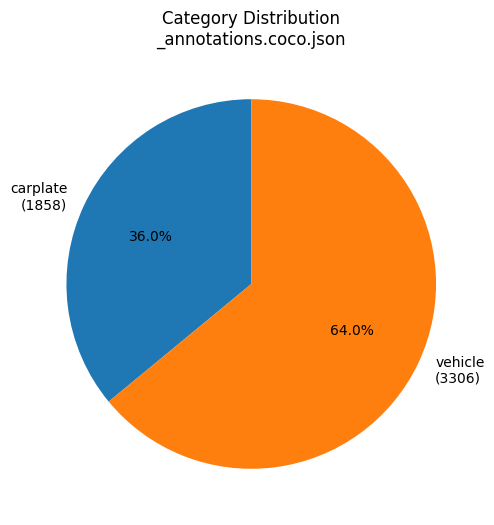

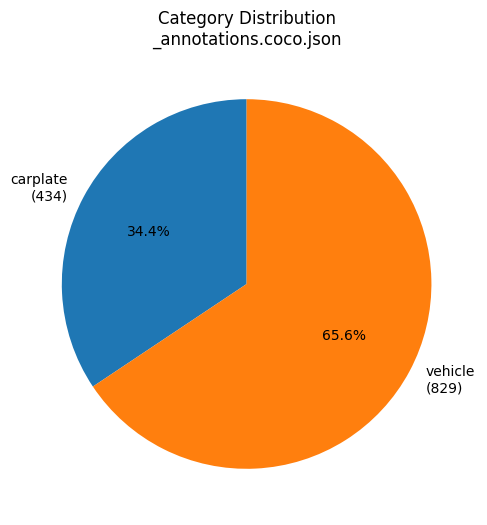

In [ ]:
import matplotlib.pyplot as plt

def visualize_category_distribution(json_path):
    with open(json_path) as f:
        data = json.load(f)

    # 统计类别分布
    cat_counts = Counter(ann['category_id'] for ann in data['annotations'])
    cats = sorted(data['categories'], key=lambda x: x['id'])

    # 绘制饼图
    plt.figure(figsize=(10, 6))
    plt.pie(
        [cat_counts.get(c['id'], 0) for c in cats],
        labels=[f"{c['name']}\n({cat_counts.get(c['id'], 0)})" for c in cats],
        autopct='%1.1f%%',
        startangle=90
    )
    plt.title(f"Category Distribution\n{json_path.split('/')[-1]}")
    plt.show()

# 可视化展示
visualize_category_distribution("/content/merged_dataset_split/train/_annotations.coco.json")
visualize_category_distribution("/content/merged_dataset_split/val/_annotations.coco.json")

## 4. transformer. custom dataset with argument

In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from PIL import Image
import os
import numpy as np
import time
from collections import defaultdict

# --- 基础数据预处理 ---
def get_transform():
    return torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])

# --- 基础COCO数据集类 ---
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, ann_file):
        self.root = root
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = get_transform()

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        img = self.transform(img)
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([img_id]),
            "area": torch.as_tensor([ann['area'] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.as_tensor([ann['iscrowd'] for ann in anns], dtype=torch.int64)
        }
        return img, target

    def __len__(self):
        return len(self.ids)

# --- 创建数据集和数据加载器 ---
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CocoDataset(
    root="/content/merged_dataset_split/train",
    ann_file="/content/merged_dataset_split/train/_annotations.coco.json"
)

val_dataset = CocoDataset(
    root="/content/merged_dataset_split/val",
    ann_file="/content/merged_dataset_split/val/_annotations.coco.json"
)

train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)



loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


## pretrain model load

In [9]:
import torch
import torchvision
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from PIL import Image
import os
import numpy as np
import time
from collections import defaultdict


In [10]:
# --- 模型初始化 ---
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes)
    return model

model = get_model(num_classes=3)  # 2 classes + background


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 193MB/s]


## baseline model Train

Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.49s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.865
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.626
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.355
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.637
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.647
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

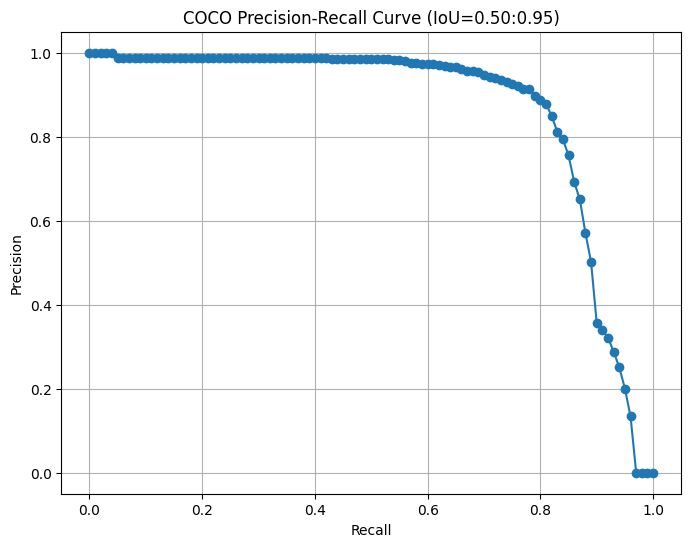


Epoch 1/5 | Time: 222.48s | Train Loss: 0.4018
  Global mAP@[.5:.95]: 0.5636
  Global Recall@100 : 0.6466
  🔥 New best model saved with mAP: 0.5636
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.891
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.590
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.293
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.342
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.624

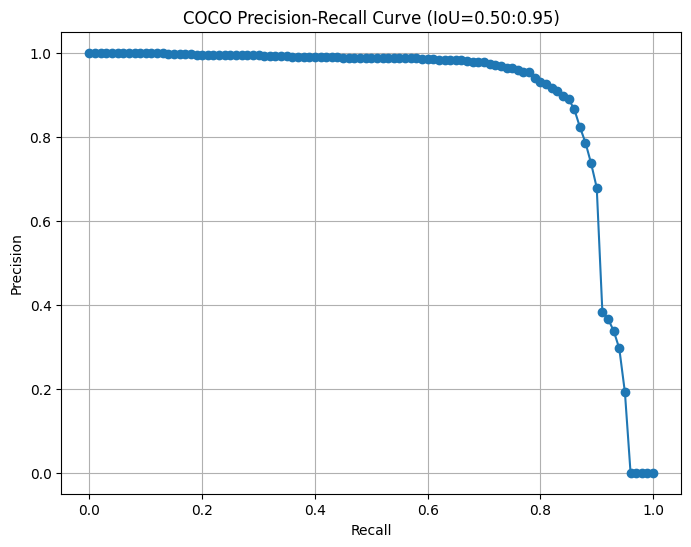


Epoch 2/5 | Time: 220.94s | Train Loss: 0.2766
  Global mAP@[.5:.95]: 0.5539
  Global Recall@100 : 0.6306
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.875
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.179
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.368
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.643
 Average Recall     (AR) @[ IoU=0.50:0.95

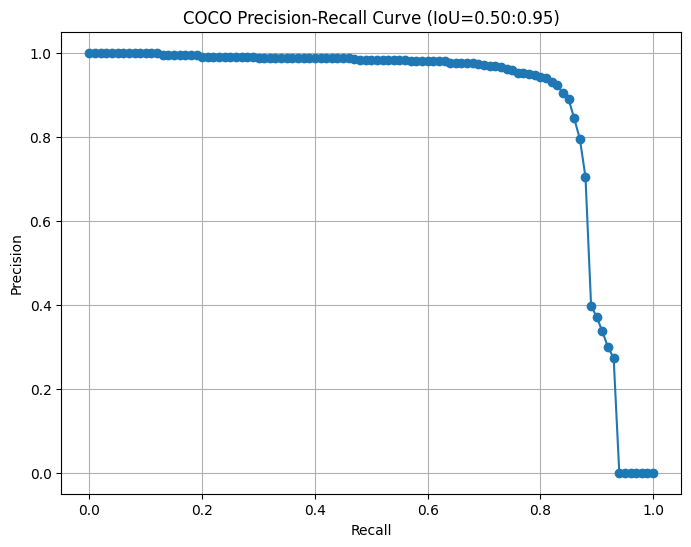


Epoch 3/5 | Time: 220.98s | Train Loss: 0.2337
  Global mAP@[.5:.95]: 0.5757
  Global Recall@100 : 0.6500
  🔥 New best model saved with mAP: 0.5757
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.51s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.604
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.886
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.390
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.661
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.661

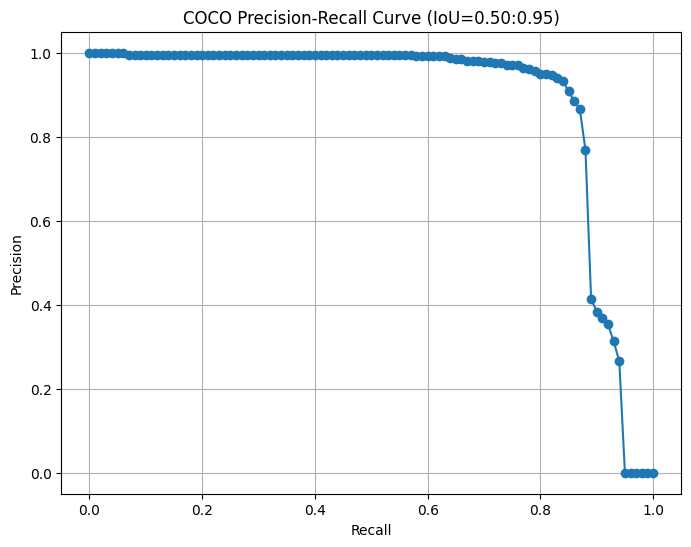


Epoch 4/5 | Time: 220.48s | Train Loss: 0.1871
  Global mAP@[.5:.95]: 0.6041
  Global Recall@100 : 0.6668
  🔥 New best model saved with mAP: 0.6041
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.609
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.891
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.667
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.271
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.402
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.666
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.382
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.669

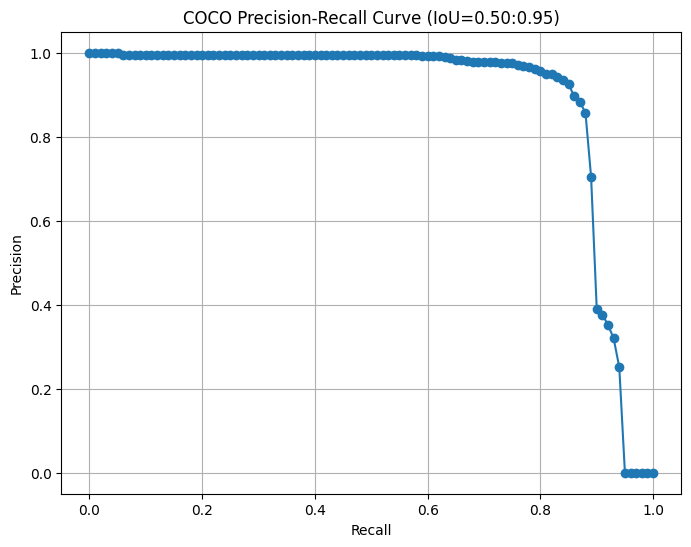


Epoch 5/5 | Time: 222.81s | Train Loss: 0.1734
  Global mAP@[.5:.95]: 0.6093
  Global Recall@100 : 0.6749
  🔥 New best model saved with mAP: 0.6093
Training completed!


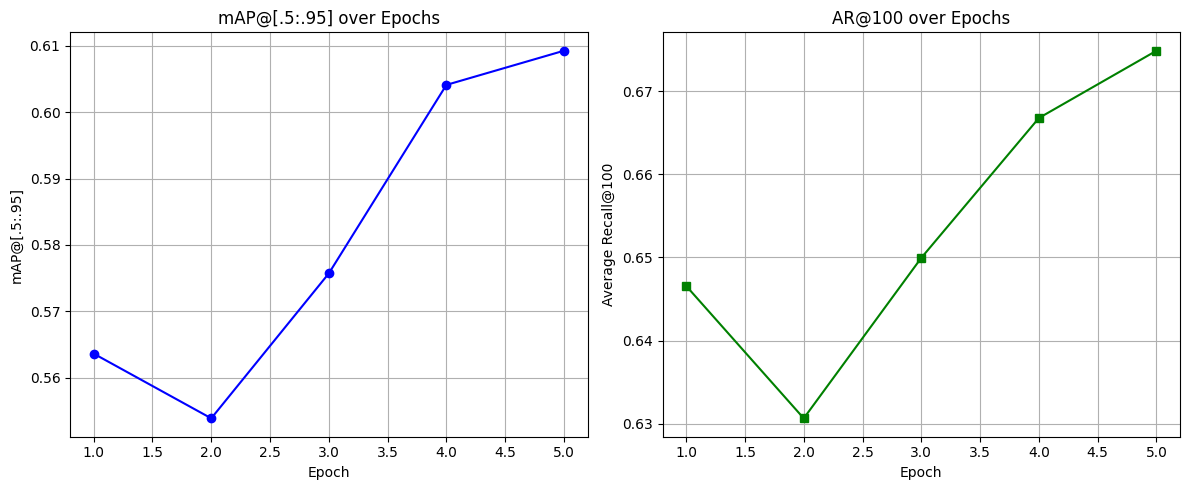

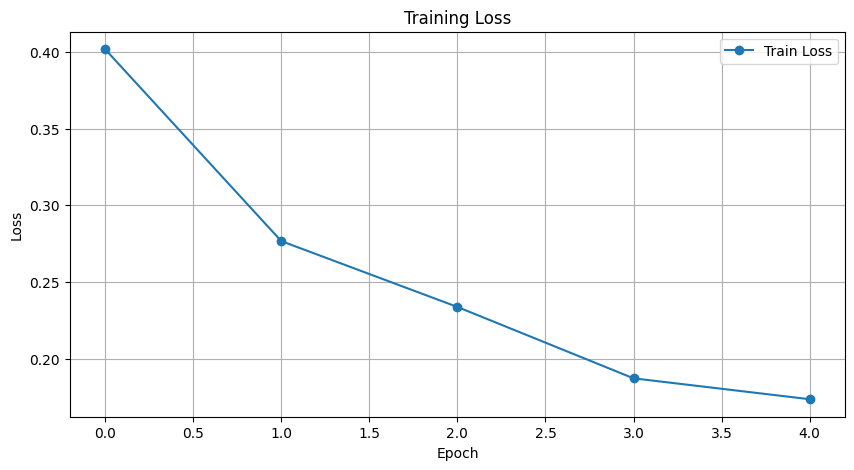

In [ ]:
import torch
import time
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import copy
import json
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np

# --- 训练设置 ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# --- COCO 全局评估函数 ---
def coco_evaluate(model, data_loader, device):
    model.eval()
    results = []
    image_ids = []
    cpu_device = torch.device("cpu")

    # 遍历验证集
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        for target, output in zip(targets, outputs):
            image_id = target["image_id"].item()
            boxes = output["boxes"].tolist()
            scores = output["scores"].tolist()
            labels = output["labels"].tolist()

            for box, score, label in zip(boxes, scores, labels):
                x_min, y_min, x_max, y_max = box
                results.append({
                    "image_id": image_id,
                    "category_id": label,
                    "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                    "score": score
                })
            image_ids.append(image_id)

    # 保存预测结果并进行 COCO 评估
    with tempfile.TemporaryDirectory() as tmpdirname:
        res_file = os.path.join(tmpdirname, "results.json")
        with open(res_file, "w") as f:
            json.dump(results, f, indent=4)

        coco_gt = data_loader.dataset.coco  # 使用验证集中的 COCO 对象
        coco_dt = coco_gt.loadRes(res_file)

        coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval.params.imgIds = list(set(image_ids))
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # 获取全局指标
        stats = coco_eval.stats
        metrics = {
            "mAP@[.5:.95]": stats[0],
            "Recall@100": stats[8]  # AR@100
        }

        # 可视化 COCO Precision Matrix
        plot_precision_matrix(coco_eval)

    return metrics


# --- 可视化 Precision Matrix 函数 ---
def plot_precision_matrix(coco_eval):
    precisions = coco_eval.eval['precision']
    # precision: [TxRxKxAxM]，我们只取 IoU=0.50:0.95 的所有类、所有 area、maxDets=100 的平均
    precision = precisions[0, :, :, 0, 2]  # iou=0.5, area=all, maxDets=100

    # 取每一类的最大 recall 值的 precision 平均
    precision = np.mean(precision, axis=1)  # 每个 recall 下的平均
    recall = coco_eval.params.recThrs

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o')
    plt.title("COCO Precision-Recall Curve (IoU=0.50:0.95)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()


# --- 训练循环 ---
num_epochs = 5
best_map = 0.0

# --- 存储每个 epoch 的评估指标 ---
epoch_maps = []
epoch_ars = []

# 在训练循环外定义存储列表
train_losses = []

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0  # 重置每个 epoch 的累积 loss

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()  # 累积 loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    # 计算平均 train loss
    avg_train_loss = running_loss / len(train_loader)
    # 在每个 epoch 结束后记录
    train_losses.append(avg_train_loss)


    # 验证并获取全局指标
    val_metrics = coco_evaluate(model, val_loader, device)

    # 打印验证结果
    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f}")
    print(f"  Global mAP@[.5:.95]: {val_metrics['mAP@[.5:.95]']:.4f}")
    print(f"  Global Recall@100 : {val_metrics['Recall@100']:.4f}")

    # 保存最优模型
    if val_metrics["mAP@[.5:.95]"] > best_map:
        best_map = val_metrics["mAP@[.5:.95]"]
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  🔥 New best model saved with mAP: {best_map:.4f}")

    # 记录每个 epoch 的指标
    epoch_maps.append(val_metrics["mAP@[.5:.95]"])
    epoch_ars.append(val_metrics["Recall@100"])


print("Training completed!")

# --- 可视化训练过程中每个 epoch 的 mAP 和 AR ---
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# mAP 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_maps, marker='o', color='blue')
plt.title("mAP@[.5:.95] over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP@[.5:.95]")
plt.grid(True)

# AR 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_ars, marker='s', color='green')
plt.title("AR@100 over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Recall@100")
plt.grid(True)

plt.tight_layout()
plt.show()



# 训练结束后绘制曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()


## model 2（increase more transform）

In [11]:
def get_transform(train=False):
    transforms = []
    # 始终转换为Tensor
    transforms.append(torchvision.transforms.ToTensor())

    if train:
        # 训练时的数据增强
        transforms.extend([
            # 随机水平翻转 (对车牌检测很有用，因为车牌可能出现在车辆左右侧)
            torchvision.transforms.RandomHorizontalFlip(p=0.5),

            # 颜色抖动 - 增强对不同光照条件的鲁棒性
            torchvision.transforms.ColorJitter(
                brightness=0.2,  # 亮度调整
                contrast=0.2,    # 对比度调整
                saturation=0.2,  # 饱和度调整
                hue=0.1          # 色相调整(小心不要太大，会影响颜色识别)
            ),

            # 随机调整锐度 - 增强对模糊图像的鲁棒性
            torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),

            # 标准化 (使用ImageNet的均值和标准差)
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    else:
        # 验证/测试时只做标准化
        transforms.append(
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        )

    return torchvision.transforms.Compose(transforms)


# --- 基础COCO数据集类 ---
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, ann_file):
        self.root = root
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = get_transform()

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        img = self.transform(img)
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([img_id]),
            "area": torch.as_tensor([ann['area'] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.as_tensor([ann['iscrowd'] for ann in anns], dtype=torch.int64)
        }
        return img, target

    def __len__(self):
        return len(self.ids)

# --- 创建数据集和数据加载器 ---
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CocoDataset(
    root="/content/merged_dataset_split/train",
    ann_file="/content/merged_dataset_split/train/_annotations.coco.json"
)

val_dataset = CocoDataset(
    root="/content/merged_dataset_split/val",
    ann_file="/content/merged_dataset_split/val/_annotations.coco.json"
)

train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.871
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.583
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.260
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.351
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.614
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

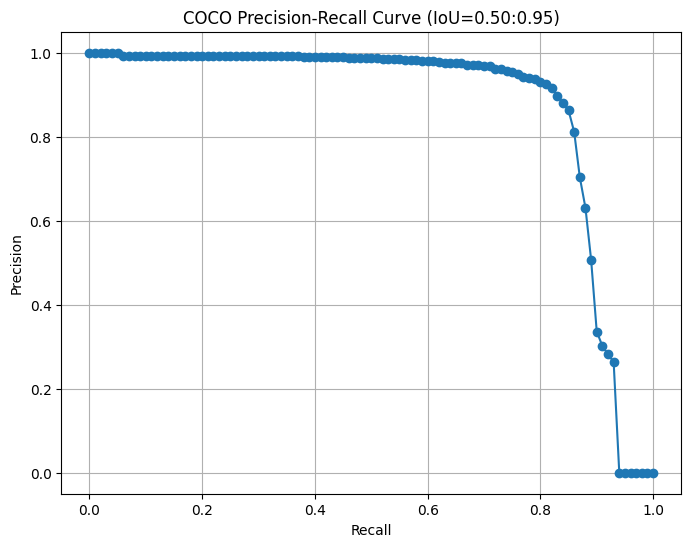


Epoch 1/5 | Time: 229.86s | Train Loss: 0.2923
  Global mAP@[.5:.95]: 0.5397
  Global Recall@100 : 0.6142
  🔥 New best model saved with mAP: 0.5397
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.37s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.574
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.627
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.197
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.323
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.635

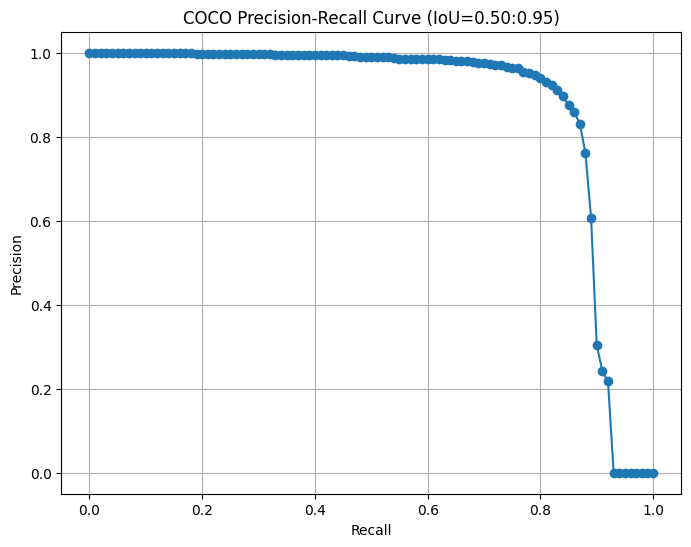


Epoch 2/5 | Time: 229.01s | Train Loss: 0.2282
  Global mAP@[.5:.95]: 0.5735
  Global Recall@100 : 0.6393
  🔥 New best model saved with mAP: 0.5735
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.619
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.200
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.616
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.356
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.624

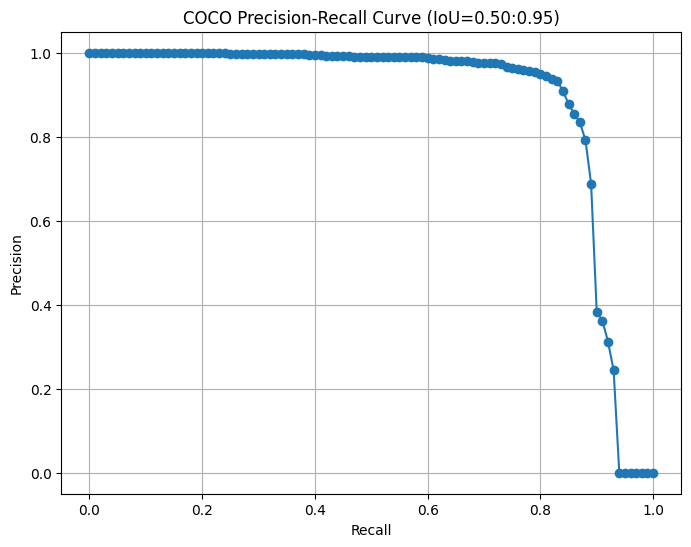


Epoch 3/5 | Time: 229.49s | Train Loss: 0.1954
  Global mAP@[.5:.95]: 0.5631
  Global Recall@100 : 0.6285
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.602
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.879
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.195
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.662
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.386
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.660
 Average Recall     (AR) @[ IoU=0.50:0.95

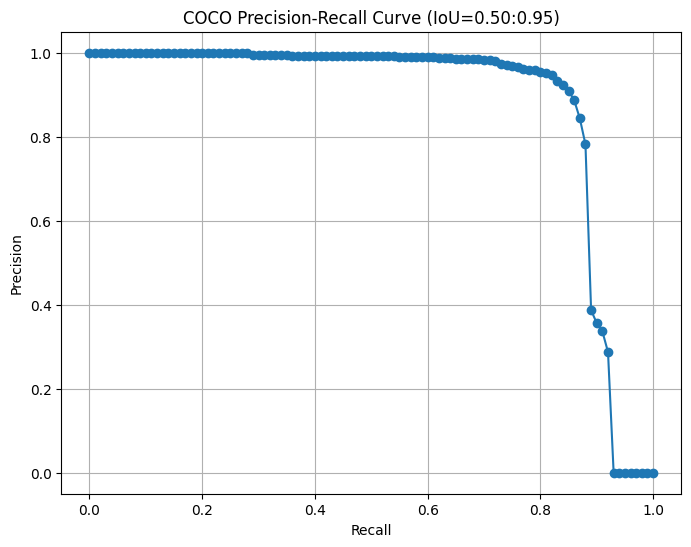


Epoch 4/5 | Time: 227.62s | Train Loss: 0.1550
  Global mAP@[.5:.95]: 0.6020
  Global Recall@100 : 0.6632
  🔥 New best model saved with mAP: 0.6020
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.876
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.653
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.204
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.370
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.384
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.660

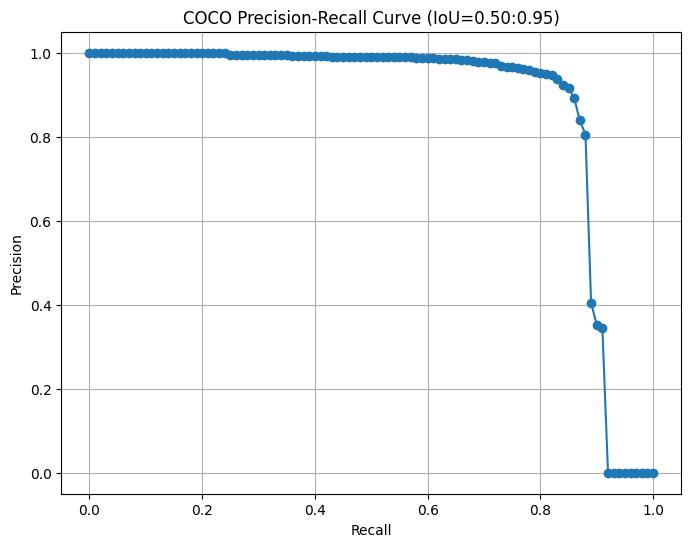


Epoch 5/5 | Time: 228.30s | Train Loss: 0.1423
  Global mAP@[.5:.95]: 0.6028
  Global Recall@100 : 0.6635
  🔥 New best model saved with mAP: 0.6028
Training completed!


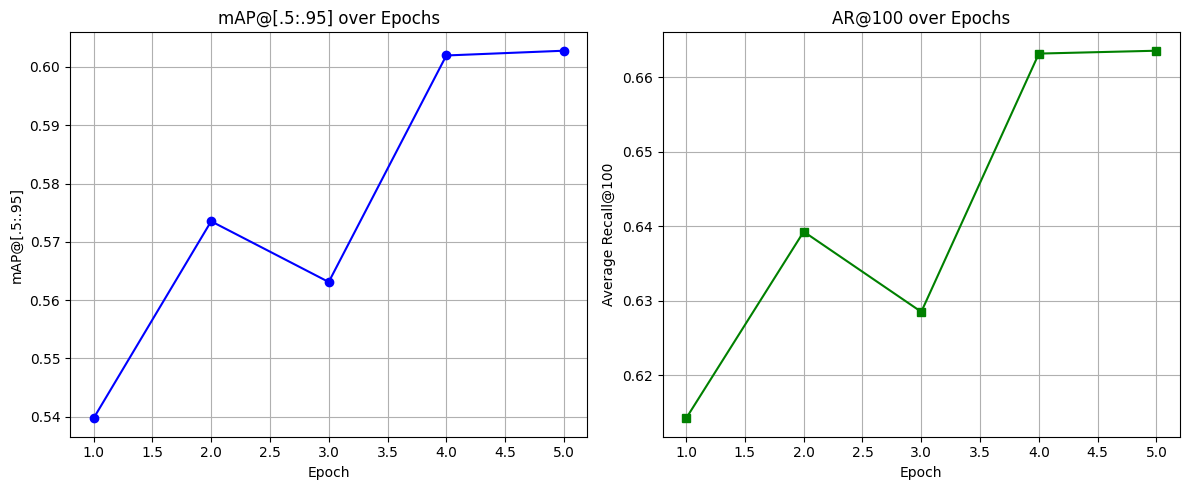

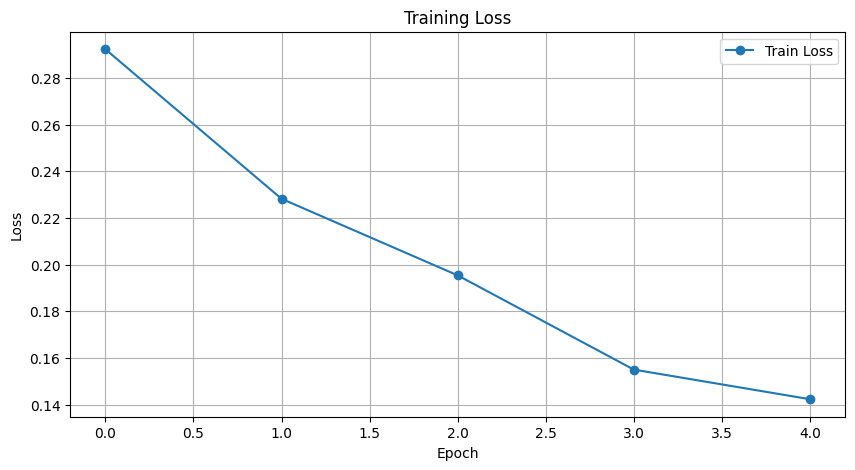

In [ ]:
import torch
import time
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import copy
import json
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np

# --- 训练设置 ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# --- COCO 全局评估函数 ---
def coco_evaluate(model, data_loader, device):
    model.eval()
    results = []
    image_ids = []
    cpu_device = torch.device("cpu")

    # 遍历验证集
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        for target, output in zip(targets, outputs):
            image_id = target["image_id"].item()
            boxes = output["boxes"].tolist()
            scores = output["scores"].tolist()
            labels = output["labels"].tolist()

            for box, score, label in zip(boxes, scores, labels):
                x_min, y_min, x_max, y_max = box
                results.append({
                    "image_id": image_id,
                    "category_id": label,
                    "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                    "score": score
                })
            image_ids.append(image_id)

    # 保存预测结果并进行 COCO 评估
    with tempfile.TemporaryDirectory() as tmpdirname:
        res_file = os.path.join(tmpdirname, "results.json")
        with open(res_file, "w") as f:
            json.dump(results, f, indent=4)

        coco_gt = data_loader.dataset.coco  # 使用验证集中的 COCO 对象
        coco_dt = coco_gt.loadRes(res_file)

        coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval.params.imgIds = list(set(image_ids))
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # 获取全局指标
        stats = coco_eval.stats
        metrics = {
            "mAP@[.5:.95]": stats[0],
            "Recall@100": stats[8]  # AR@100
        }

        # 可视化 COCO Precision Matrix
        plot_precision_matrix(coco_eval)

    return metrics


# --- 可视化 Precision Matrix 函数 ---
def plot_precision_matrix(coco_eval):
    precisions = coco_eval.eval['precision']
    # precision: [TxRxKxAxM]，我们只取 IoU=0.50:0.95 的所有类、所有 area、maxDets=100 的平均
    precision = precisions[0, :, :, 0, 2]  # iou=0.5, area=all, maxDets=100

    # 取每一类的最大 recall 值的 precision 平均
    precision = np.mean(precision, axis=1)  # 每个 recall 下的平均
    recall = coco_eval.params.recThrs

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o')
    plt.title("COCO Precision-Recall Curve (IoU=0.50:0.95)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()


# --- 训练循环 ---
num_epochs = 5
best_map = 0.0

# --- 存储每个 epoch 的评估指标 ---
epoch_maps = []
epoch_ars = []

# 在训练循环外定义存储列表
train_losses = []

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0  # 重置每个 epoch 的累积 loss

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()  # 累积 loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    # 计算平均 train loss
    avg_train_loss = running_loss / len(train_loader)
    # 在每个 epoch 结束后记录
    train_losses.append(avg_train_loss)


    # 验证并获取全局指标
    val_metrics = coco_evaluate(model, val_loader, device)

    # 打印验证结果
    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f}")
    print(f"  Global mAP@[.5:.95]: {val_metrics['mAP@[.5:.95]']:.4f}")
    print(f"  Global Recall@100 : {val_metrics['Recall@100']:.4f}")

    # 保存最优模型
    if val_metrics["mAP@[.5:.95]"] > best_map:
        best_map = val_metrics["mAP@[.5:.95]"]
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  🔥 New best model saved with mAP: {best_map:.4f}")

    # 记录每个 epoch 的指标
    epoch_maps.append(val_metrics["mAP@[.5:.95]"])
    epoch_ars.append(val_metrics["Recall@100"])


print("Training completed!")

# --- 可视化训练过程中每个 epoch 的 mAP 和 AR ---
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# mAP 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_maps, marker='o', color='blue')
plt.title("mAP@[.5:.95] over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP@[.5:.95]")
plt.grid(True)

# AR 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_ars, marker='s', color='green')
plt.title("AR@100 over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Recall@100")
plt.grid(True)

plt.tight_layout()
plt.show()



# 训练结束后绘制曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()


## model 3 (add 类别加权采样)
-performance not well
-not use it

In [ ]:

from torch.utils.data import WeightedRandomSampler
import numpy as np

# --- Modified dataset class with transform option ---
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, ann_file, train=False):
        self.root = root
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = get_transform(train)
        self.train = train

        # Precompute class weights
        self.class_counts = {1: 0, 2: 0}  # carplate: 1, vehicle: 2
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            for ann in anns:
                self.class_counts[ann['category_id']] += 1

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        img = self.transform(img)
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([img_id]),
            "area": torch.as_tensor([ann['area'] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.as_tensor([ann['iscrowd'] for ann in anns], dtype=torch.int64)
        }
        return img, target

    def __len__(self):
        return len(self.ids)

    def get_sample_weights(self):
        """Calculate weights for each image based on carplate presence"""
        weights = []
        for img_id in self.ids:
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            anns = self.coco.loadAnns(ann_ids)
            # Higher weight if image contains carplate (class 1)
            has_carplate = any(ann['category_id'] == 1 for ann in anns)
            weights.append(2.0 if has_carplate else 1.0)  # Adjust factor as needed
        return weights

# --- 创建数据集和数据加载器 ---
def collate_fn(batch):
        return tuple(zip(*batch))

# --- Create datasets ---
train_dataset = CocoDataset(
    root="/content/merged_dataset_split/train",
    ann_file="/content/merged_dataset_split/train/_annotations.coco.json",
    train=True
)

val_dataset = CocoDataset(
    root="/content/merged_dataset_split/val",
    ann_file="/content/merged_dataset_split/val/_annotations.coco.json",
    train=False
)

# --- Create WeightedRandomSampler for training ---
train_weights = train_dataset.get_sample_weights()
train_sampler = WeightedRandomSampler(
    weights=train_weights,
    num_samples=len(train_weights),
    replacement=True
)

# --- Create data loaders ---
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    sampler=train_sampler,  # Use sampler instead of shuffle
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.60s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.557
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.858
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.344
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.624
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.636
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

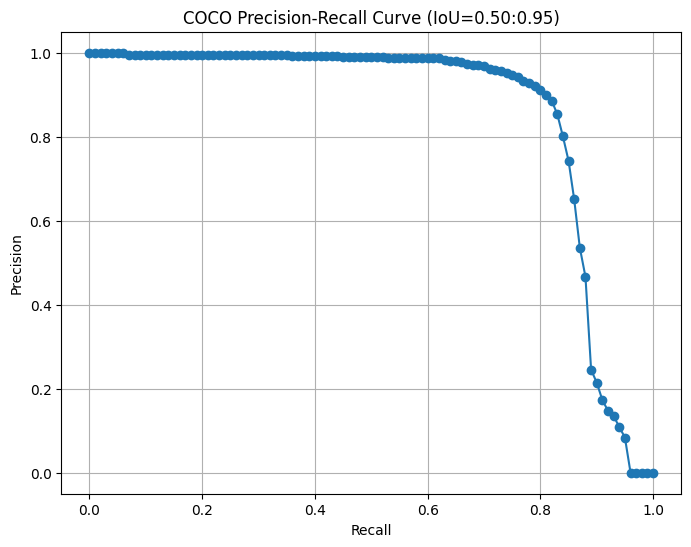


Epoch 1/5 | Time: 2114.07s | Train Loss: 0.4667
  Global mAP@[.5:.95]: 0.5575
  Global Recall@100 : 0.6364
  🔥 New best model saved with mAP: 0.5575
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.61s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.853
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.607
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.164
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.62

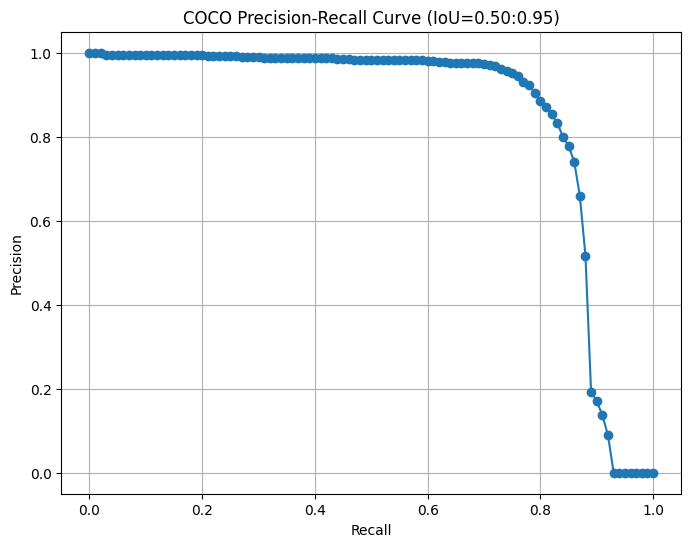


Epoch 2/5 | Time: 2156.82s | Train Loss: 0.4089
  Global mAP@[.5:.95]: 0.5524
  Global Recall@100 : 0.6347
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.73s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.563
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.856
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.173
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.353
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.620
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.370
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.626
 Average Recall     (AR) @[ IoU=0.50:0.9

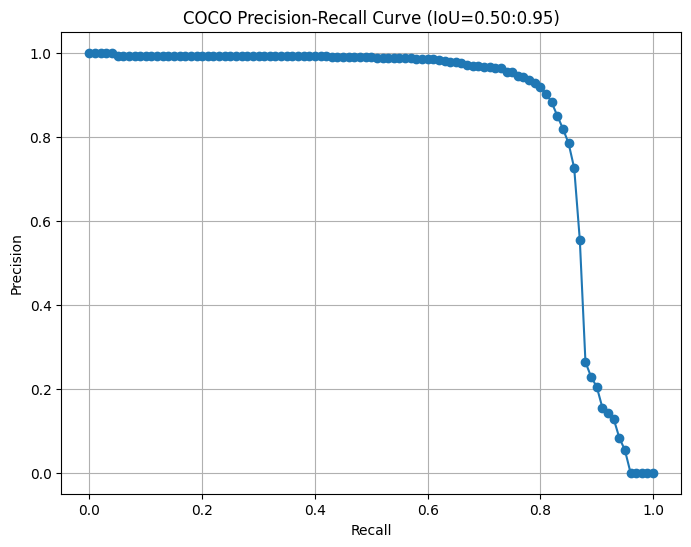


Epoch 3/5 | Time: 2123.37s | Train Loss: 0.3906
  Global mAP@[.5:.95]: 0.5627
  Global Recall@100 : 0.6357
  🔥 New best model saved with mAP: 0.5627
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.64s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.867
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.615
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.181
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.371
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.64

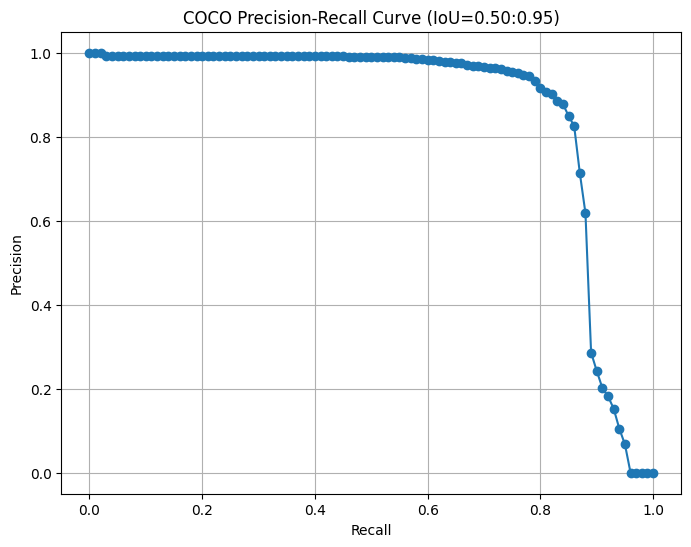


Epoch 4/5 | Time: 2121.21s | Train Loss: 0.3587
  Global mAP@[.5:.95]: 0.5760
  Global Recall@100 : 0.6524
  🔥 New best model saved with mAP: 0.5760
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.87s).
Accumulating evaluation results...
DONE (t=0.10s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.573
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.863
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.628
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.183
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.355
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.64

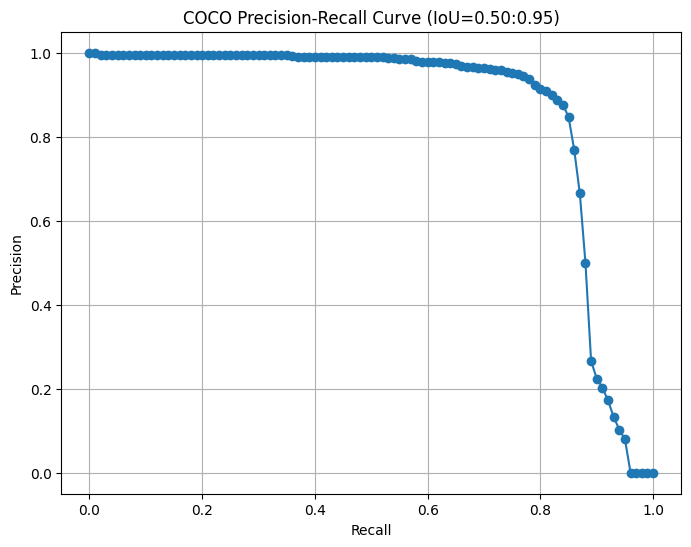


Epoch 5/5 | Time: 2049.91s | Train Loss: 0.3578
  Global mAP@[.5:.95]: 0.5730
  Global Recall@100 : 0.6537
Training completed!


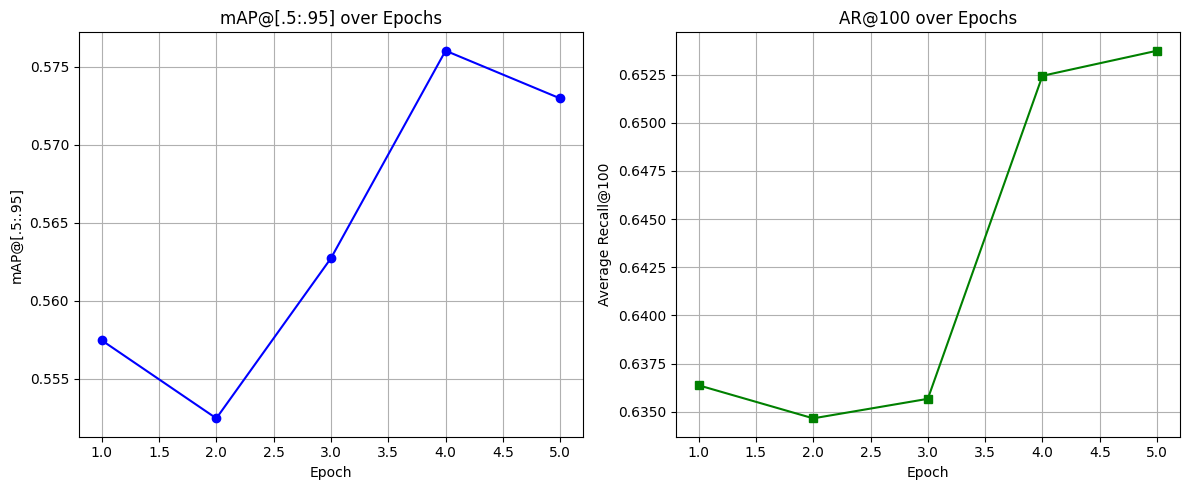

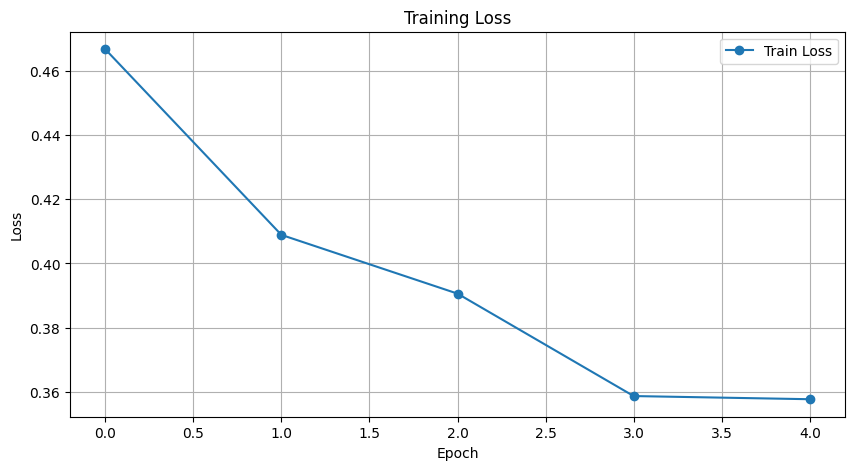

In [ ]:
import torch
import time
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import copy
import json
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np

# --- 训练设置 ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# --- COCO 全局评估函数 ---
def coco_evaluate(model, data_loader, device):
    model.eval()
    results = []
    image_ids = []
    cpu_device = torch.device("cpu")

    # 遍历验证集
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        for target, output in zip(targets, outputs):
            image_id = target["image_id"].item()
            boxes = output["boxes"].tolist()
            scores = output["scores"].tolist()
            labels = output["labels"].tolist()

            for box, score, label in zip(boxes, scores, labels):
                x_min, y_min, x_max, y_max = box
                results.append({
                    "image_id": image_id,
                    "category_id": label,
                    "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                    "score": score
                })
            image_ids.append(image_id)

    # 保存预测结果并进行 COCO 评估
    with tempfile.TemporaryDirectory() as tmpdirname:
        res_file = os.path.join(tmpdirname, "results.json")
        with open(res_file, "w") as f:
            json.dump(results, f, indent=4)

        coco_gt = data_loader.dataset.coco  # 使用验证集中的 COCO 对象
        coco_dt = coco_gt.loadRes(res_file)

        coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval.params.imgIds = list(set(image_ids))
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # 获取全局指标
        stats = coco_eval.stats
        metrics = {
            "mAP@[.5:.95]": stats[0],
            "Recall@100": stats[8]  # AR@100
        }

        # 可视化 COCO Precision Matrix
        plot_precision_matrix(coco_eval)

    return metrics


# --- 可视化 Precision Matrix 函数 ---
def plot_precision_matrix(coco_eval):
    precisions = coco_eval.eval['precision']
    # precision: [TxRxKxAxM]，我们只取 IoU=0.50:0.95 的所有类、所有 area、maxDets=100 的平均
    precision = precisions[0, :, :, 0, 2]  # iou=0.5, area=all, maxDets=100

    # 取每一类的最大 recall 值的 precision 平均
    precision = np.mean(precision, axis=1)  # 每个 recall 下的平均
    recall = coco_eval.params.recThrs

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o')
    plt.title("COCO Precision-Recall Curve (IoU=0.50:0.95)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()


# --- 训练循环 ---
num_epochs = 5
best_map = 0.0

# --- 存储每个 epoch 的评估指标 ---
epoch_maps = []
epoch_ars = []

# 在训练循环外定义存储列表
train_losses = []

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0  # 重置每个 epoch 的累积 loss

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()  # 累积 loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    # 计算平均 train loss
    avg_train_loss = running_loss / len(train_loader)
    # 在每个 epoch 结束后记录
    train_losses.append(avg_train_loss)


    # 验证并获取全局指标
    val_metrics = coco_evaluate(model, val_loader, device)

    # 打印验证结果
    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f}")
    print(f"  Global mAP@[.5:.95]: {val_metrics['mAP@[.5:.95]']:.4f}")
    print(f"  Global Recall@100 : {val_metrics['Recall@100']:.4f}")

    # 保存最优模型
    if val_metrics["mAP@[.5:.95]"] > best_map:
        best_map = val_metrics["mAP@[.5:.95]"]
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  🔥 New best model saved with mAP: {best_map:.4f}")

    # 记录每个 epoch 的指标
    epoch_maps.append(val_metrics["mAP@[.5:.95]"])
    epoch_ars.append(val_metrics["Recall@100"])


print("Training completed!")

# --- 可视化训练过程中每个 epoch 的 mAP 和 AR ---
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# mAP 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_maps, marker='o', color='blue')
plt.title("mAP@[.5:.95] over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP@[.5:.95]")
plt.grid(True)

# AR 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_ars, marker='s', color='green')
plt.title("AR@100 over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Recall@100")
plt.grid(True)

plt.tight_layout()
plt.show()



# 训练结束后绘制曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model 4

In [ ]:
def get_transform(train=False):
    transforms = []
    # 始终转换为Tensor
    transforms.append(torchvision.transforms.ToTensor())

    if train:
        # 训练时的数据增强
        transforms.extend([
            # 随机水平翻转 (对车牌检测很有用，因为车牌可能出现在车辆左右侧)
            torchvision.transforms.RandomHorizontalFlip(p=0.5),

            # 颜色抖动 - 增强对不同光照条件的鲁棒性
            torchvision.transforms.ColorJitter(
                brightness=0.2,  # 亮度调整
                contrast=0.2,    # 对比度调整
                saturation=0.2,  # 饱和度调整
                hue=0.1          # 色相调整(小心不要太大，会影响颜色识别)
            ),

            # 随机调整锐度 - 增强对模糊图像的鲁棒性
            torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),

            # 标准化 (使用ImageNet的均值和标准差)
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    else:
        # 验证/测试时只做标准化
        transforms.append(
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        )

    return torchvision.transforms.Compose(transforms)


# --- 基础COCO数据集类 ---
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, ann_file):
        self.root = root
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = get_transform()

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        img = self.transform(img)
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([img_id]),
            "area": torch.as_tensor([ann['area'] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.as_tensor([ann['iscrowd'] for ann in anns], dtype=torch.int64)
        }
        return img, target

    def __len__(self):
        return len(self.ids)

# --- 创建数据集和数据加载器 ---
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CocoDataset(
    root="/content/merged_dataset_split/train",
    ann_file="/content/merged_dataset_split/train/_annotations.coco.json"
)

val_dataset = CocoDataset(
    root="/content/merged_dataset_split/val",
    ann_file="/content/merged_dataset_split/val/_annotations.coco.json"
)

train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
# --- 模型初始化 ---
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes)
    return model

model = get_model(num_classes=3)  # 2 classes + background


In [ ]:
import torch
import time
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import copy
import json
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np



In [ ]:

# --- 训练设置 ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.002, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)



Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.56s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.507
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.834
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.320
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.307
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.553
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.344
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.585
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

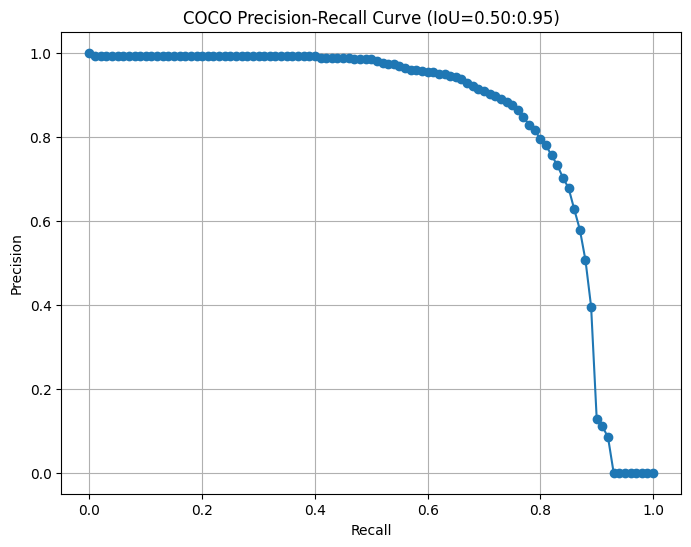


Epoch 1/10 | Time: 224.26s | Train Loss: 0.3361
  Global mAP@[.5:.95]: 0.5075
  Global Recall@100 : 0.5976
  🔥 New best model saved with mAP: 0.5075
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.835
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.543
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.289
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.295
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.563
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.342
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.58

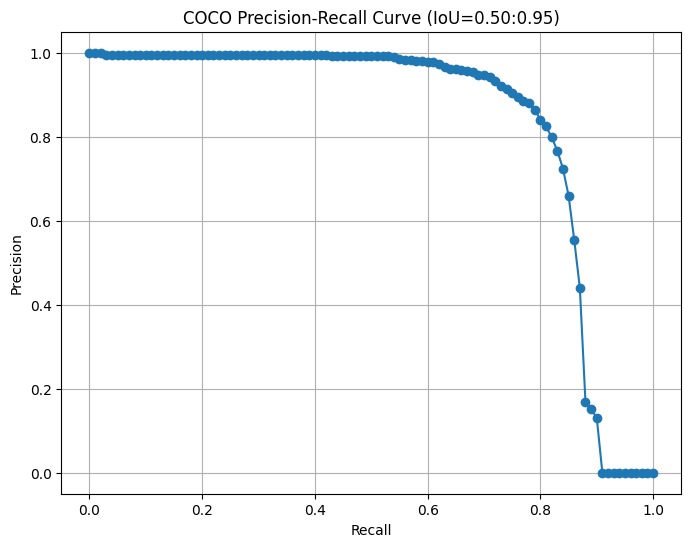


Epoch 2/10 | Time: 226.04s | Train Loss: 0.2980
  Global mAP@[.5:.95]: 0.5110
  Global Recall@100 : 0.5907
  🔥 New best model saved with mAP: 0.5110
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.836
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.322
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.570
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.349
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.59

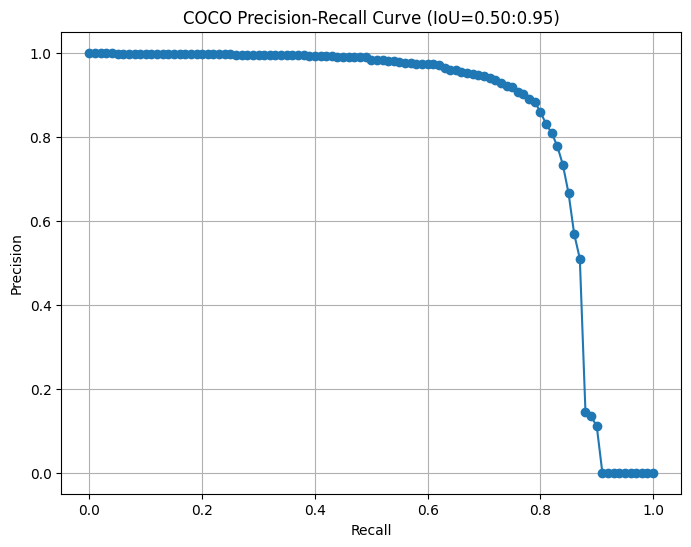


Epoch 3/10 | Time: 228.36s | Train Loss: 0.2636
  Global mAP@[.5:.95]: 0.5204
  Global Recall@100 : 0.5975
  🔥 New best model saved with mAP: 0.5204
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.845
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.327
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.60

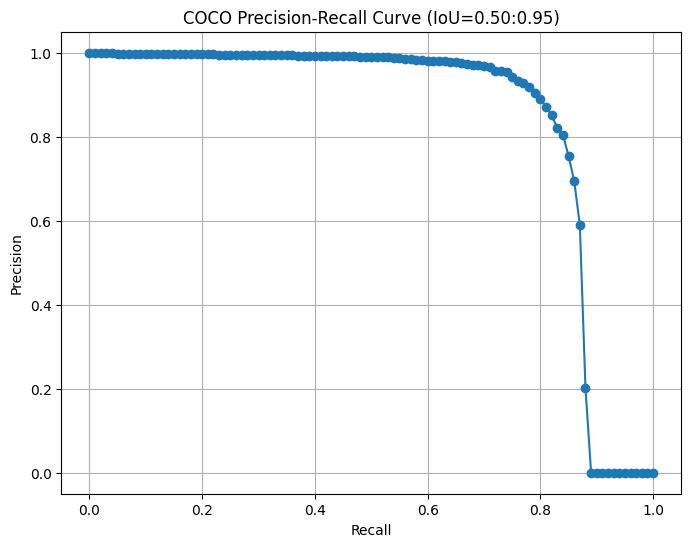


Epoch 4/10 | Time: 227.35s | Train Loss: 0.2010
  Global mAP@[.5:.95]: 0.5461
  Global Recall@100 : 0.6084
  🔥 New best model saved with mAP: 0.5461
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.843
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.611
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.300
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.60

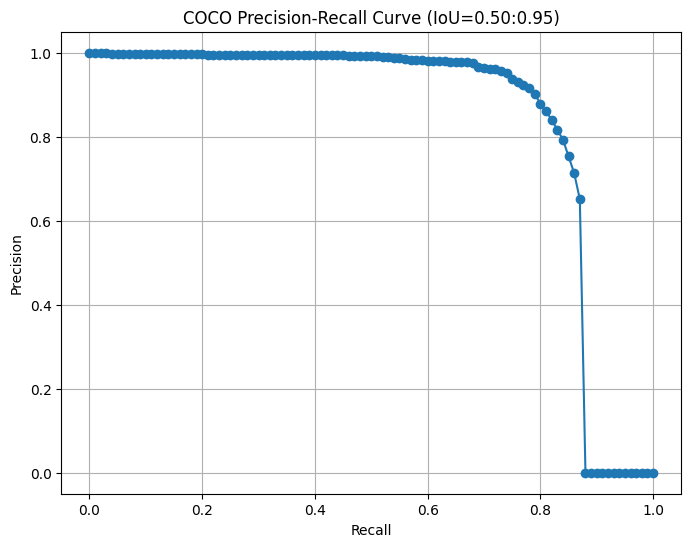


Epoch 5/10 | Time: 227.83s | Train Loss: 0.1753
  Global mAP@[.5:.95]: 0.5442
  Global Recall@100 : 0.6070
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.845
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.607
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.263
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.9

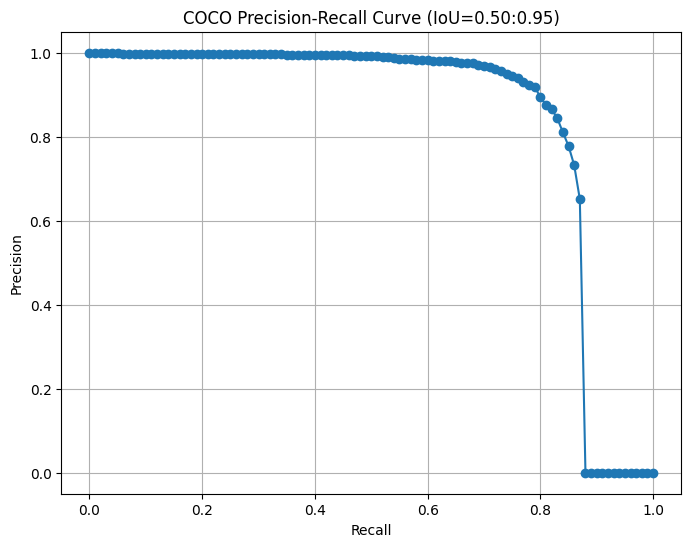


Epoch 6/10 | Time: 227.65s | Train Loss: 0.1600
  Global mAP@[.5:.95]: 0.5444
  Global Recall@100 : 0.6052
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.546
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.838
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.610
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.298
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.363
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.602
 Average Recall     (AR) @[ IoU=0.50:0.9

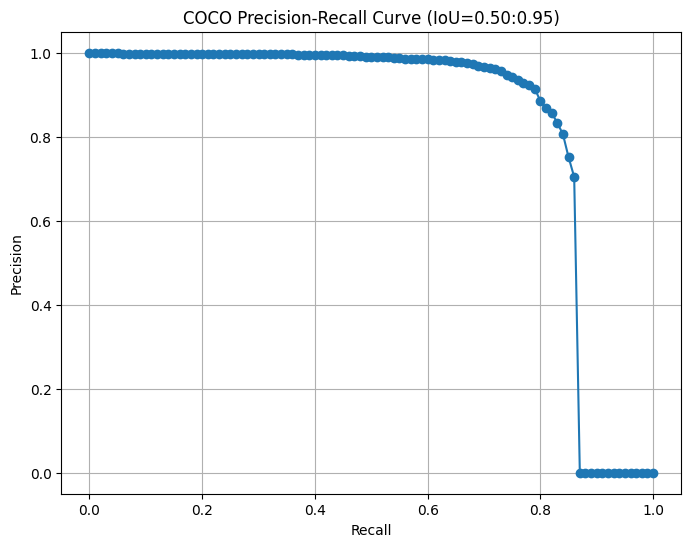


Epoch 7/10 | Time: 226.16s | Train Loss: 0.1460
  Global mAP@[.5:.95]: 0.5460
  Global Recall@100 : 0.6060
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.837
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.605
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.255
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.597
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.601
 Average Recall     (AR) @[ IoU=0.50:0.9

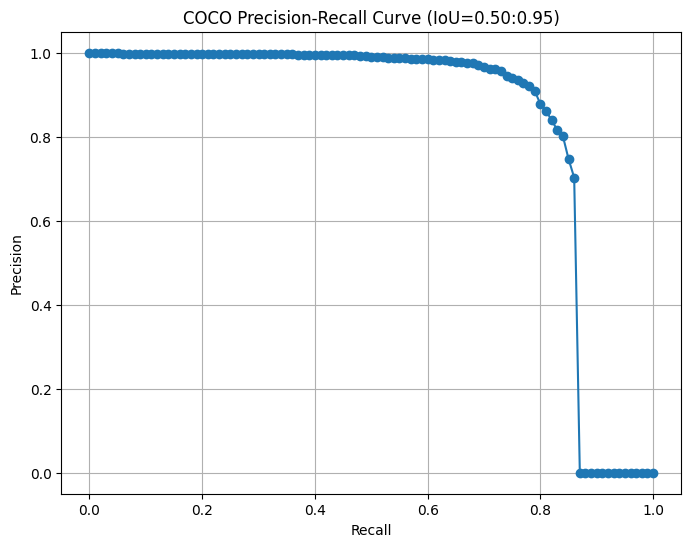


Epoch 8/10 | Time: 227.62s | Train Loss: 0.1441
  Global mAP@[.5:.95]: 0.5454
  Global Recall@100 : 0.6049
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.49s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.837
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.606
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.329
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.600
 Average Recall     (AR) @[ IoU=0.50:0.9

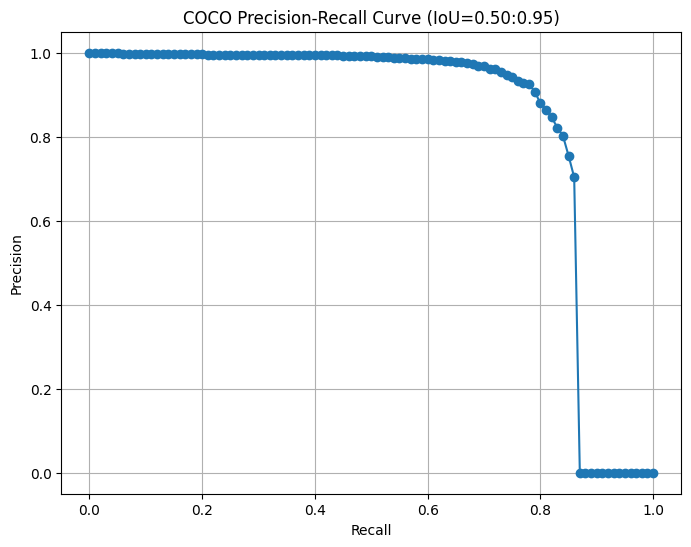


Epoch 9/10 | Time: 227.43s | Train Loss: 0.1418
  Global mAP@[.5:.95]: 0.5438
  Global Recall@100 : 0.6036
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.544
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.837
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.608
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.257
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.330
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.596
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.361
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.599
 Average Recall     (AR) @[ IoU=0.50:0.9

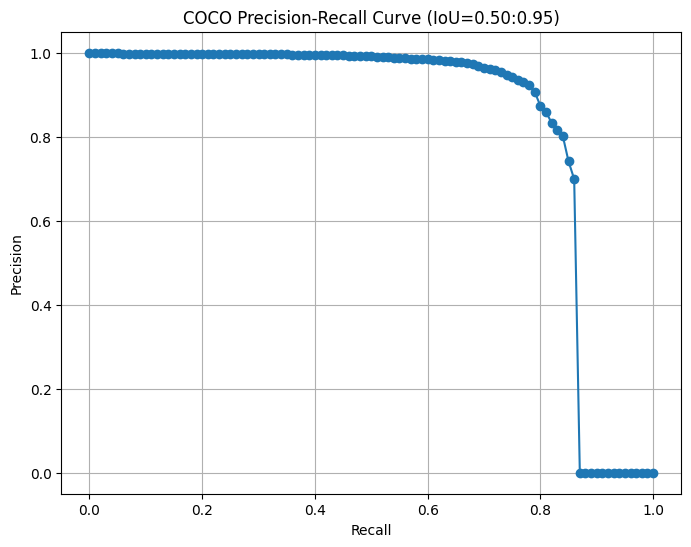


Epoch 10/10 | Time: 225.30s | Train Loss: 0.1406
  Global mAP@[.5:.95]: 0.5439
  Global Recall@100 : 0.6031
Training completed!


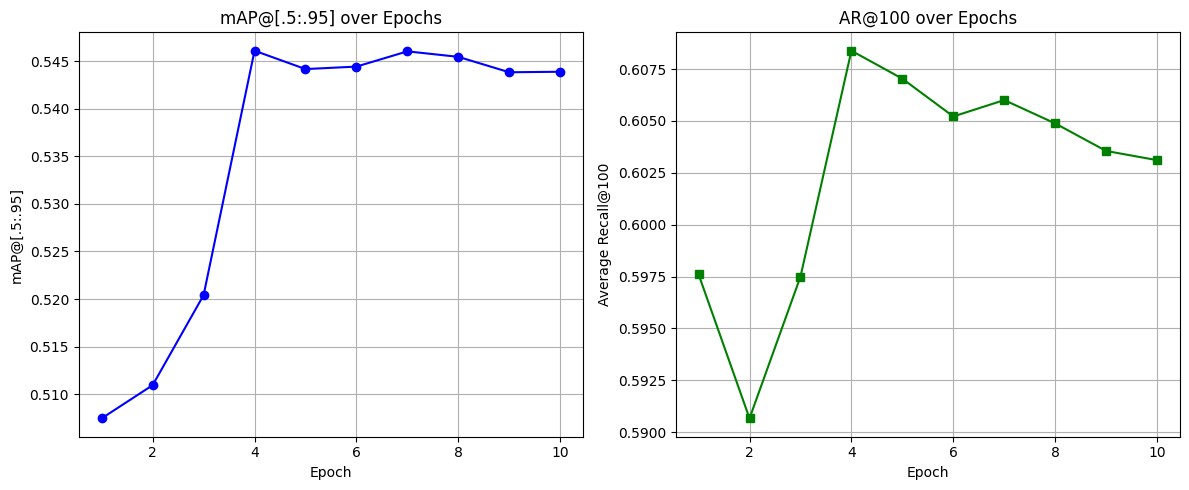

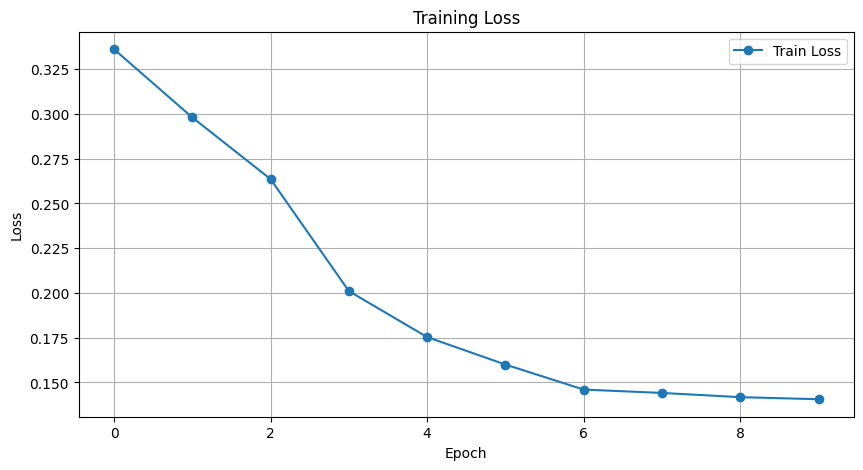

In [ ]:


# --- COCO 全局评估函数 ---
def coco_evaluate(model, data_loader, device):
    model.eval()
    results = []
    image_ids = []
    cpu_device = torch.device("cpu")

    # 遍历验证集
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        for target, output in zip(targets, outputs):
            image_id = target["image_id"].item()
            boxes = output["boxes"].tolist()
            scores = output["scores"].tolist()
            labels = output["labels"].tolist()

            for box, score, label in zip(boxes, scores, labels):
                x_min, y_min, x_max, y_max = box
                results.append({
                    "image_id": image_id,
                    "category_id": label,
                    "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                    "score": score
                })
            image_ids.append(image_id)

    # 保存预测结果并进行 COCO 评估
    with tempfile.TemporaryDirectory() as tmpdirname:
        res_file = os.path.join(tmpdirname, "results.json")
        with open(res_file, "w") as f:
            json.dump(results, f, indent=4)

        coco_gt = data_loader.dataset.coco  # 使用验证集中的 COCO 对象
        coco_dt = coco_gt.loadRes(res_file)

        coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval.params.imgIds = list(set(image_ids))
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # 获取全局指标
        stats = coco_eval.stats
        metrics = {
            "mAP@[.5:.95]": stats[0],
            "Recall@100": stats[8]  # AR@100
        }

        # 可视化 COCO Precision Matrix
        plot_precision_matrix(coco_eval)

    return metrics


# --- 可视化 Precision Matrix 函数 ---
def plot_precision_matrix(coco_eval):
    precisions = coco_eval.eval['precision']
    # precision: [TxRxKxAxM]，我们只取 IoU=0.50:0.95 的所有类、所有 area、maxDets=100 的平均
    precision = precisions[0, :, :, 0, 2]  # iou=0.5, area=all, maxDets=100

    # 取每一类的最大 recall 值的 precision 平均
    precision = np.mean(precision, axis=1)  # 每个 recall 下的平均
    recall = coco_eval.params.recThrs

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o')
    plt.title("COCO Precision-Recall Curve (IoU=0.50:0.95)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()


# --- 训练循环 ---
num_epochs = 10
best_map = 0.0

# --- 存储每个 epoch 的评估指标 ---
epoch_maps = []
epoch_ars = []

# 在训练循环外定义存储列表
train_losses = []

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0  # 重置每个 epoch 的累积 loss

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()  # 累积 loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    # 计算平均 train loss
    avg_train_loss = running_loss / len(train_loader)
    # 在每个 epoch 结束后记录
    train_losses.append(avg_train_loss)


    # 验证并获取全局指标
    val_metrics = coco_evaluate(model, val_loader, device)

    # 打印验证结果
    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f}")
    print(f"  Global mAP@[.5:.95]: {val_metrics['mAP@[.5:.95]']:.4f}")
    print(f"  Global Recall@100 : {val_metrics['Recall@100']:.4f}")

    # 保存最优模型
    if val_metrics["mAP@[.5:.95]"] > best_map:
        best_map = val_metrics["mAP@[.5:.95]"]
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  🔥 New best model saved with mAP: {best_map:.4f}")

    # 记录每个 epoch 的指标
    epoch_maps.append(val_metrics["mAP@[.5:.95]"])
    epoch_ars.append(val_metrics["Recall@100"])


print("Training completed!")

# --- 可视化训练过程中每个 epoch 的 mAP 和 AR ---
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# mAP 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_maps, marker='o', color='blue')
plt.title("mAP@[.5:.95] over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP@[.5:.95]")
plt.grid(True)

# AR 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_ars, marker='s', color='green')
plt.title("AR@100 over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Recall@100")
plt.grid(True)

plt.tight_layout()
plt.show()



# 训练结束后绘制曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()


## Model 5

In [ ]:

# --- 训练设置 ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# 方案 1：CosineAnnealing
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)


Loading and preparing results...
DONE (t=0.24s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.90s).
Accumulating evaluation results...
DONE (t=0.13s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.493
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.823
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.226
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.540
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.319
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.599
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

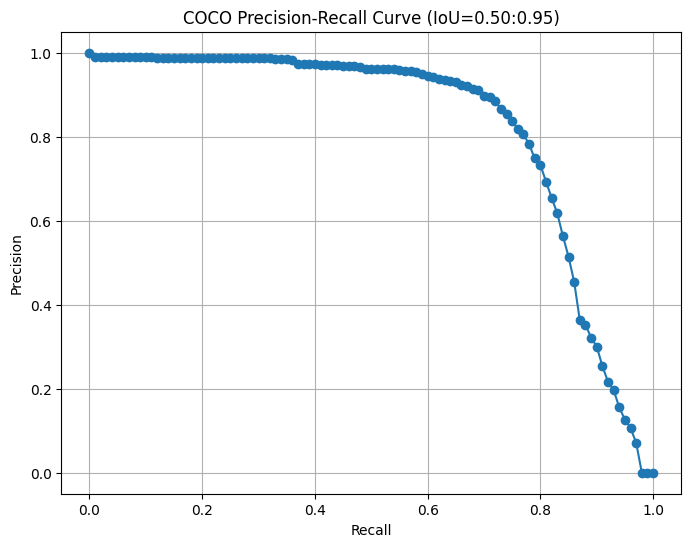


Epoch 1/10 | Time: 228.94s | Train Loss: 0.4486
  Global mAP@[.5:.95]: 0.4928
  Global Recall@100 : 0.5992
  🔥 New best model saved with mAP: 0.4928
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.47s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.545
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.324
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.604
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.343
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.62

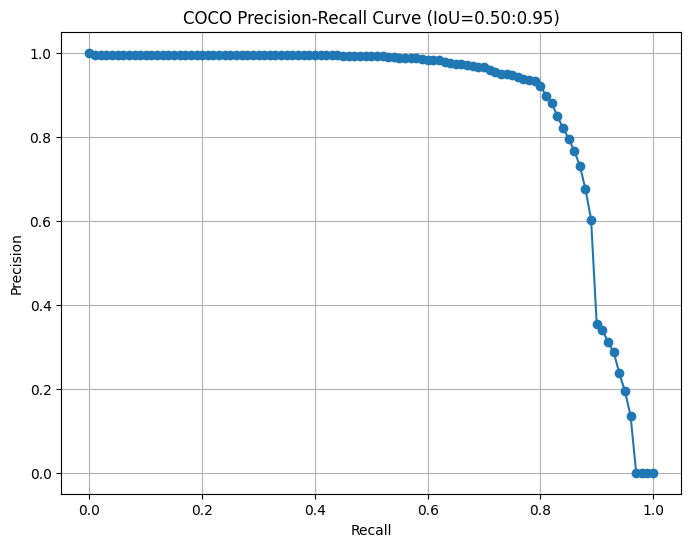


Epoch 2/10 | Time: 227.13s | Train Loss: 0.3058
  Global mAP@[.5:.95]: 0.5451
  Global Recall@100 : 0.6269
  🔥 New best model saved with mAP: 0.5451
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.555
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.865
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.581
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.332
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.611
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.360
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.62

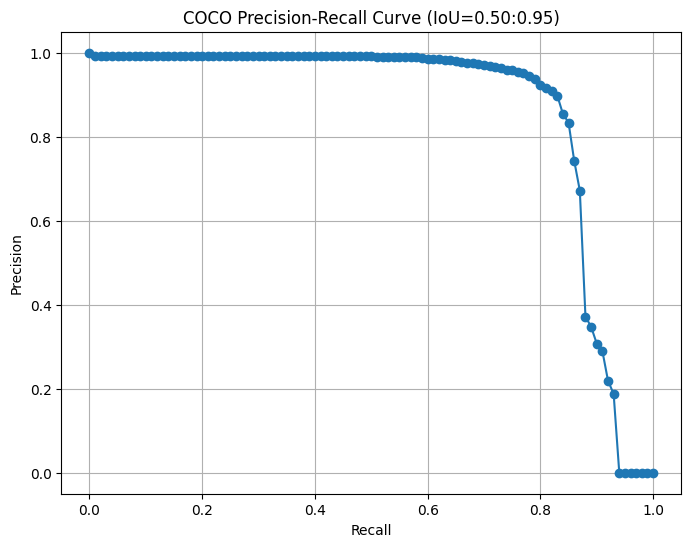


Epoch 3/10 | Time: 224.15s | Train Loss: 0.2469
  Global mAP@[.5:.95]: 0.5553
  Global Recall@100 : 0.6284
  🔥 New best model saved with mAP: 0.5553
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.574
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.884
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.354
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.635
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.365
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.64

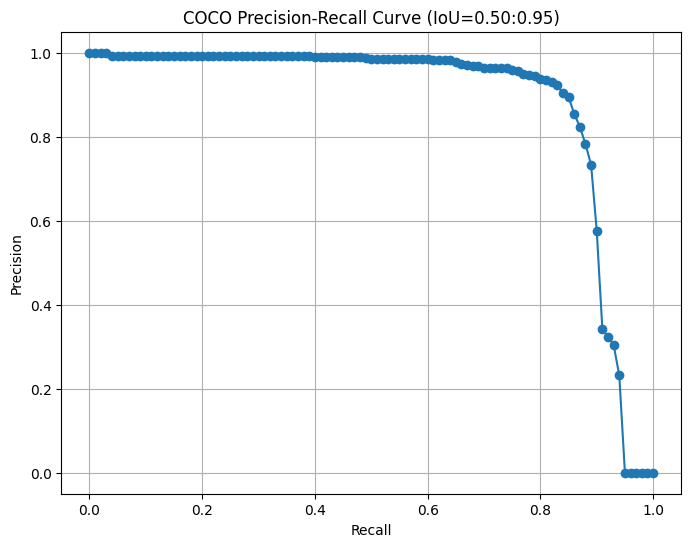


Epoch 4/10 | Time: 227.17s | Train Loss: 0.2171
  Global mAP@[.5:.95]: 0.5736
  Global Recall@100 : 0.6483
  🔥 New best model saved with mAP: 0.5736
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.577
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.877
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.618
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.362
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.633
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.367
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.63

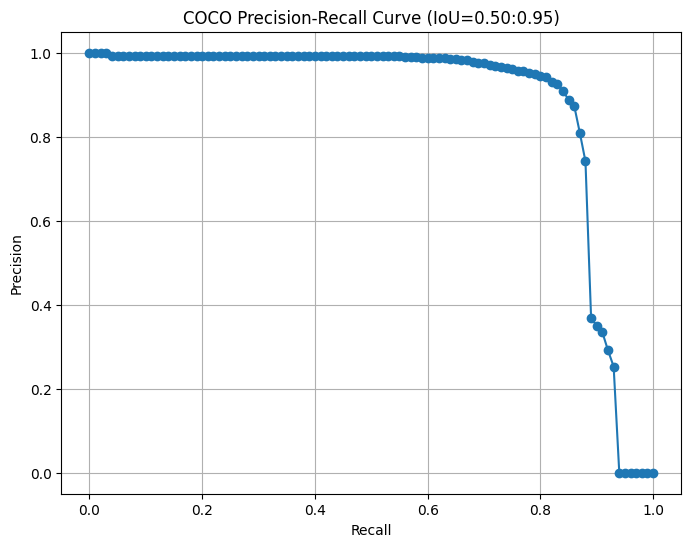


Epoch 5/10 | Time: 227.56s | Train Loss: 0.1864
  Global mAP@[.5:.95]: 0.5774
  Global Recall@100 : 0.6437
  🔥 New best model saved with mAP: 0.5774
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.579
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.873
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.624
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.273
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.632
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.372
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.64

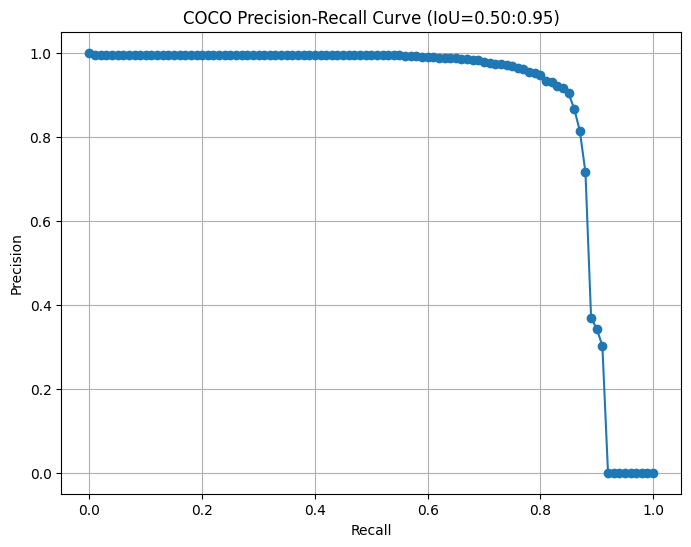


Epoch 6/10 | Time: 226.62s | Train Loss: 0.1638
  Global mAP@[.5:.95]: 0.5787
  Global Recall@100 : 0.6448
  🔥 New best model saved with mAP: 0.5787
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.32s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.582
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.872
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.620
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.266
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.64

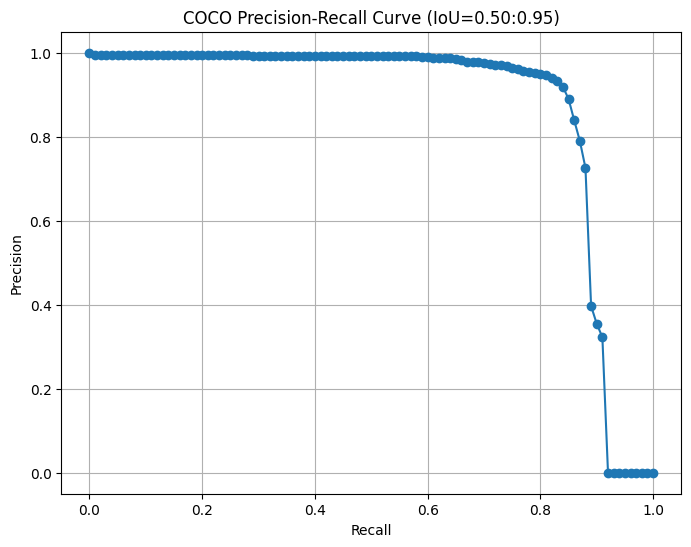


Epoch 7/10 | Time: 228.45s | Train Loss: 0.1433
  Global mAP@[.5:.95]: 0.5822
  Global Recall@100 : 0.6499
  🔥 New best model saved with mAP: 0.5822
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.588
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.873
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.636
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.242
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.644
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.64

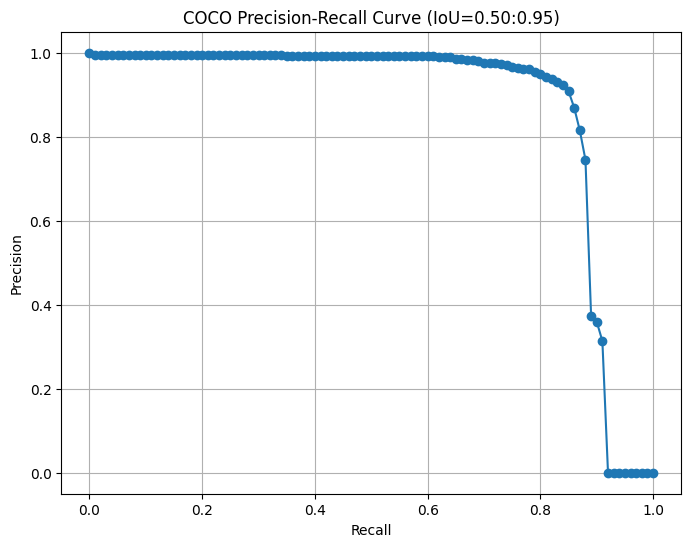


Epoch 8/10 | Time: 226.40s | Train Loss: 0.1285
  Global mAP@[.5:.95]: 0.5877
  Global Recall@100 : 0.6507
  🔥 New best model saved with mAP: 0.5877
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.584
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.870
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.251
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.364
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.64

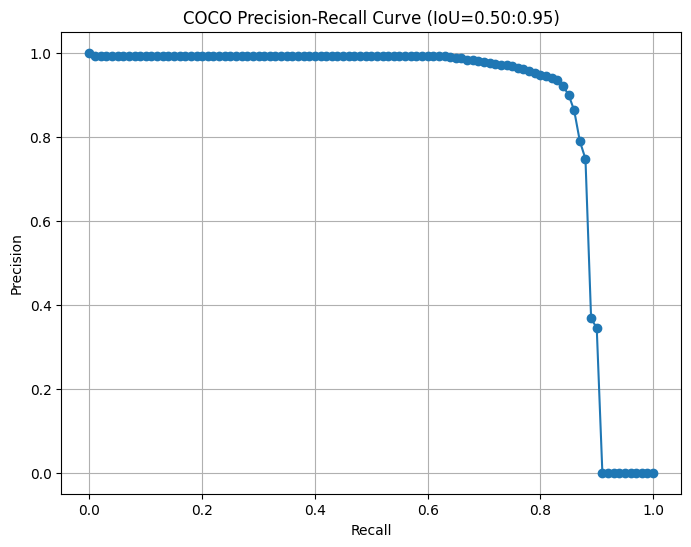


Epoch 9/10 | Time: 227.52s | Train Loss: 0.1197
  Global mAP@[.5:.95]: 0.5841
  Global Recall@100 : 0.6490
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.31s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.586
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.870
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.632
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.246
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.361
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.646
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.646
 Average Recall     (AR) @[ IoU=0.50:0.9

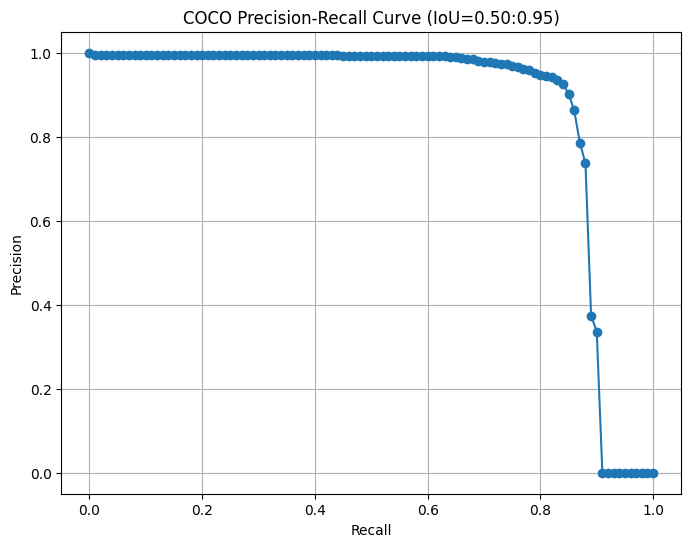


Epoch 10/10 | Time: 229.21s | Train Loss: 0.1146
  Global mAP@[.5:.95]: 0.5863
  Global Recall@100 : 0.6505
Training completed!


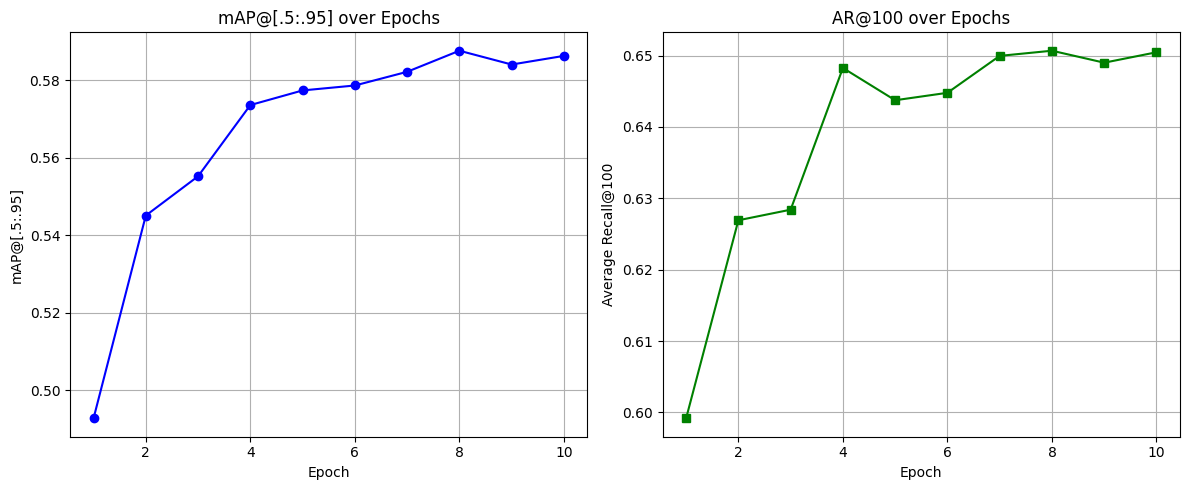

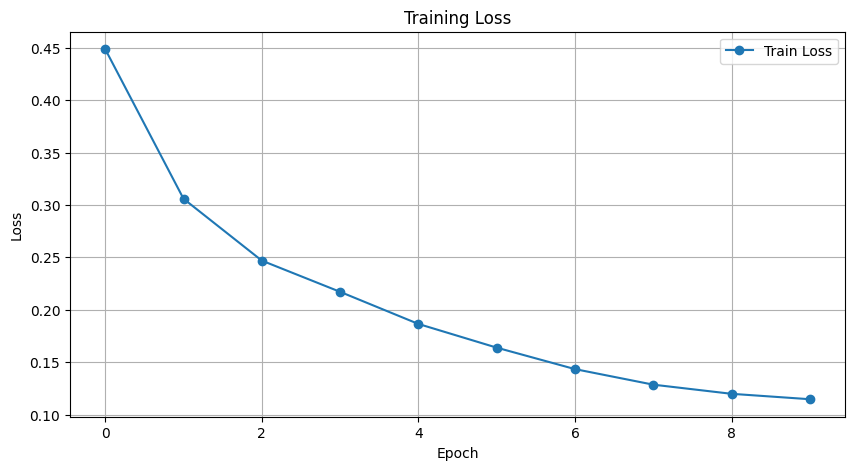

In [ ]:


# --- COCO 全局评估函数 ---
def coco_evaluate(model, data_loader, device):
    model.eval()
    results = []
    image_ids = []
    cpu_device = torch.device("cpu")

    # 遍历验证集
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        for target, output in zip(targets, outputs):
            image_id = target["image_id"].item()
            boxes = output["boxes"].tolist()
            scores = output["scores"].tolist()
            labels = output["labels"].tolist()

            for box, score, label in zip(boxes, scores, labels):
                x_min, y_min, x_max, y_max = box
                results.append({
                    "image_id": image_id,
                    "category_id": label,
                    "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                    "score": score
                })
            image_ids.append(image_id)

    # 保存预测结果并进行 COCO 评估
    with tempfile.TemporaryDirectory() as tmpdirname:
        res_file = os.path.join(tmpdirname, "results.json")
        with open(res_file, "w") as f:
            json.dump(results, f, indent=4)

        coco_gt = data_loader.dataset.coco  # 使用验证集中的 COCO 对象
        coco_dt = coco_gt.loadRes(res_file)

        coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval.params.imgIds = list(set(image_ids))
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # 获取全局指标
        stats = coco_eval.stats
        metrics = {
            "mAP@[.5:.95]": stats[0],
            "Recall@100": stats[8]  # AR@100
        }

        # 可视化 COCO Precision Matrix
        plot_precision_matrix(coco_eval)

    return metrics


# --- 可视化 Precision Matrix 函数 ---
def plot_precision_matrix(coco_eval):
    precisions = coco_eval.eval['precision']
    # precision: [TxRxKxAxM]，我们只取 IoU=0.50:0.95 的所有类、所有 area、maxDets=100 的平均
    precision = precisions[0, :, :, 0, 2]  # iou=0.5, area=all, maxDets=100

    # 取每一类的最大 recall 值的 precision 平均
    precision = np.mean(precision, axis=1)  # 每个 recall 下的平均
    recall = coco_eval.params.recThrs

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o')
    plt.title("COCO Precision-Recall Curve (IoU=0.50:0.95)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()


# --- 训练循环 ---
num_epochs = 10
best_map = 0.0

# --- 存储每个 epoch 的评估指标 ---
epoch_maps = []
epoch_ars = []

# 在训练循环外定义存储列表
train_losses = []

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0  # 重置每个 epoch 的累积 loss

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()  # 累积 loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    # 计算平均 train loss
    avg_train_loss = running_loss / len(train_loader)
    # 在每个 epoch 结束后记录
    train_losses.append(avg_train_loss)


    # 验证并获取全局指标
    val_metrics = coco_evaluate(model, val_loader, device)

    # 打印验证结果
    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f}")
    print(f"  Global mAP@[.5:.95]: {val_metrics['mAP@[.5:.95]']:.4f}")
    print(f"  Global Recall@100 : {val_metrics['Recall@100']:.4f}")

    # 保存最优模型
    if val_metrics["mAP@[.5:.95]"] > best_map:
        best_map = val_metrics["mAP@[.5:.95]"]
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  🔥 New best model saved with mAP: {best_map:.4f}")

    # 记录每个 epoch 的指标
    epoch_maps.append(val_metrics["mAP@[.5:.95]"])
    epoch_ars.append(val_metrics["Recall@100"])


print("Training completed!")

# --- 可视化训练过程中每个 epoch 的 mAP 和 AR ---
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# mAP 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_maps, marker='o', color='blue')
plt.title("mAP@[.5:.95] over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP@[.5:.95]")
plt.grid(True)

# AR 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_ars, marker='s', color='green')
plt.title("AR@100 over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Recall@100")
plt.grid(True)

plt.tight_layout()
plt.show()



# 训练结束后绘制曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()


## Final model

In [13]:
def get_transform(train=False):
    transforms = []
    # 始终转换为Tensor
    transforms.append(torchvision.transforms.ToTensor())

    if train:
        # 训练时的数据增强
        transforms.extend([
            # 随机水平翻转 (对车牌检测很有用，因为车牌可能出现在车辆左右侧)
            torchvision.transforms.RandomHorizontalFlip(p=0.5),

            # 颜色抖动 - 增强对不同光照条件的鲁棒性
            torchvision.transforms.ColorJitter(
                brightness=0.2,  # 亮度调整
                contrast=0.2,    # 对比度调整
                saturation=0.2,  # 饱和度调整
                hue=0.1          # 色相调整(小心不要太大，会影响颜色识别)
            ),

            # 随机调整锐度 - 增强对模糊图像的鲁棒性
            torchvision.transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),

            # 标准化 (使用ImageNet的均值和标准差)
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])
    else:
        # 验证/测试时只做标准化
        transforms.append(
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        )

    return torchvision.transforms.Compose(transforms)


# --- 基础COCO数据集类 ---
class CocoDataset(torch.utils.data.Dataset):
    def __init__(self, root, ann_file):
        self.root = root
        self.coco = COCO(ann_file)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.transform = get_transform()

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]

        img_path = os.path.join(self.root, img_info['file_name'])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])

        img = self.transform(img)
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64),
            "image_id": torch.tensor([img_id]),
            "area": torch.as_tensor([ann['area'] for ann in anns], dtype=torch.float32),
            "iscrowd": torch.as_tensor([ann['iscrowd'] for ann in anns], dtype=torch.int64)
        }
        return img, target

    def __len__(self):
        return len(self.ids)

# --- 创建数据集和数据加载器 ---
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = CocoDataset(
    root="/content/merged_dataset_split/train",
    ann_file="/content/merged_dataset_split/train/_annotations.coco.json"
)

val_dataset = CocoDataset(
    root="/content/merged_dataset_split/val",
    ann_file="/content/merged_dataset_split/val/_annotations.coco.json"
)

train_loader = DataLoader(
    train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)

val_loader = DataLoader(
    val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn,
    num_workers=2, pin_memory=True
)


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
from pycocotools.coco import COCO
from pycocotools import mask as coco_mask
from PIL import Image
import os
import numpy as np
import time
from collections import defaultdict


# --- 模型初始化 ---
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
        in_features, num_classes)
    return model

model = get_model(num_classes=3)  # 2 classes + background


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.50s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.850
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.551
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.175
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.589
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.347
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.608
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

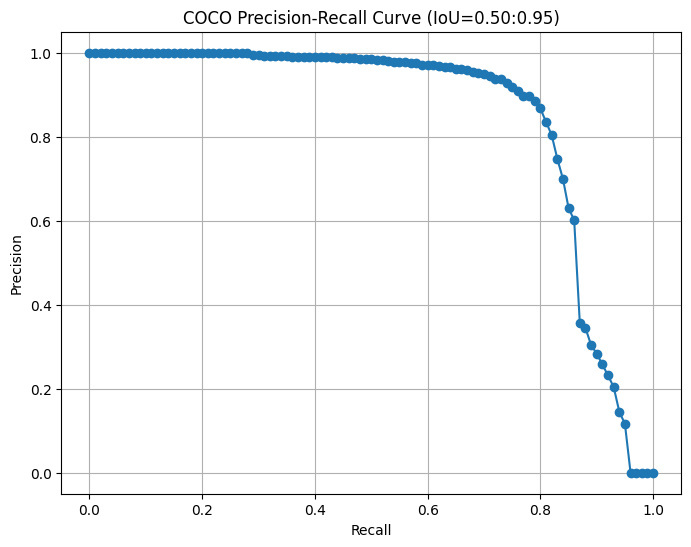


Epoch 1/20 | Time: 171.35s | Train Loss: 0.4558
  Global mAP@[.5:.95]: 0.5325
  Global Recall@100 : 0.6186
  🔥 New best model saved with mAP: 0.5325
Loading and preparing results...
DONE (t=0.19s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.54s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.548
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.878
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.269
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.343
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.599
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.62

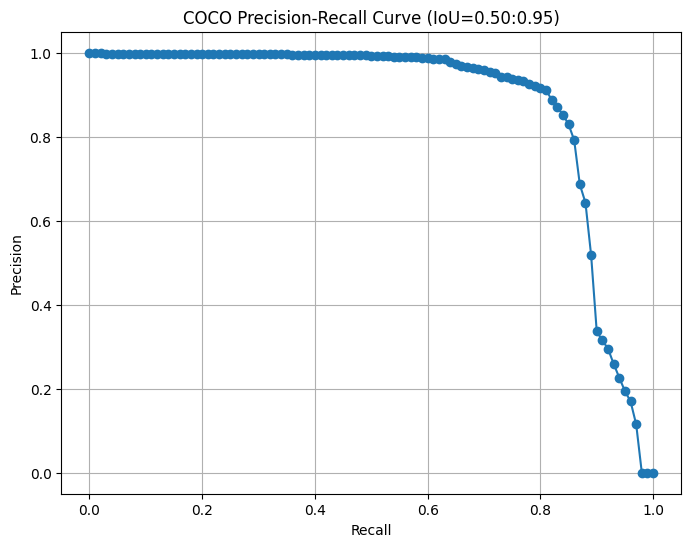


Epoch 2/20 | Time: 169.81s | Train Loss: 0.3142
  Global mAP@[.5:.95]: 0.5484
  Global Recall@100 : 0.6331
  🔥 New best model saved with mAP: 0.5484
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.07s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.565
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.872
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.597
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.236
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.349
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.631
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.358
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.62

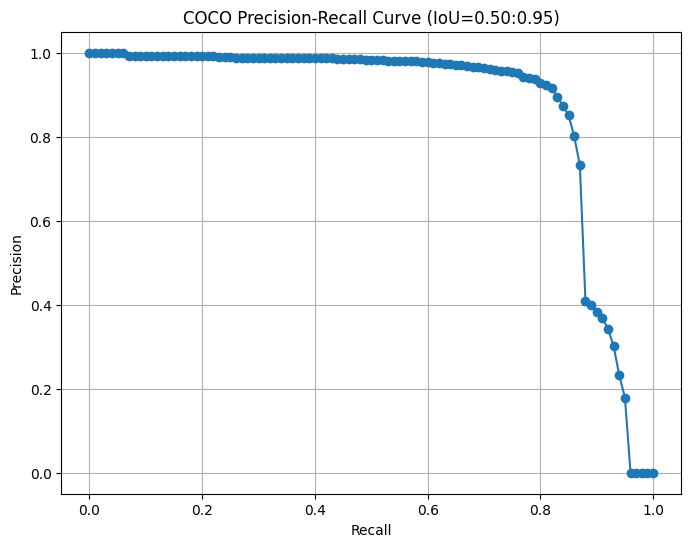


Epoch 3/20 | Time: 173.72s | Train Loss: 0.2573
  Global mAP@[.5:.95]: 0.5646
  Global Recall@100 : 0.6358
  🔥 New best model saved with mAP: 0.5646
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.37s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.887
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.637
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.193
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.380
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.653
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.65

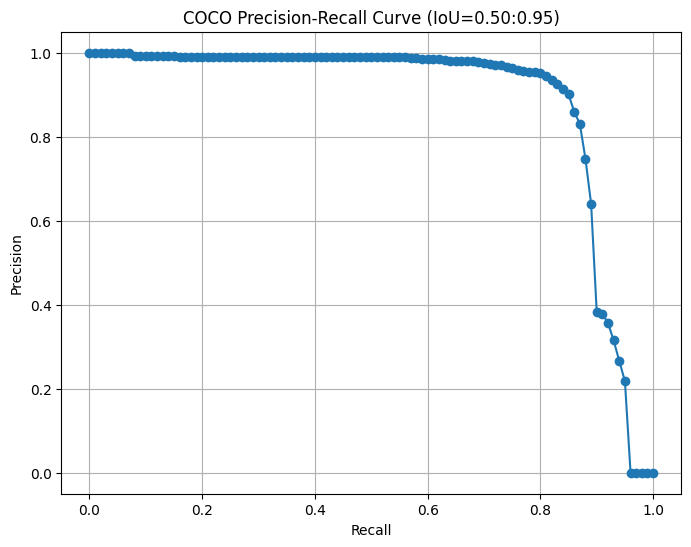


Epoch 4/20 | Time: 173.37s | Train Loss: 0.2051
  Global mAP@[.5:.95]: 0.5940
  Global Recall@100 : 0.6622
  🔥 New best model saved with mAP: 0.5940
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.52s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.603
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.643
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.210
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.664
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.380
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.66

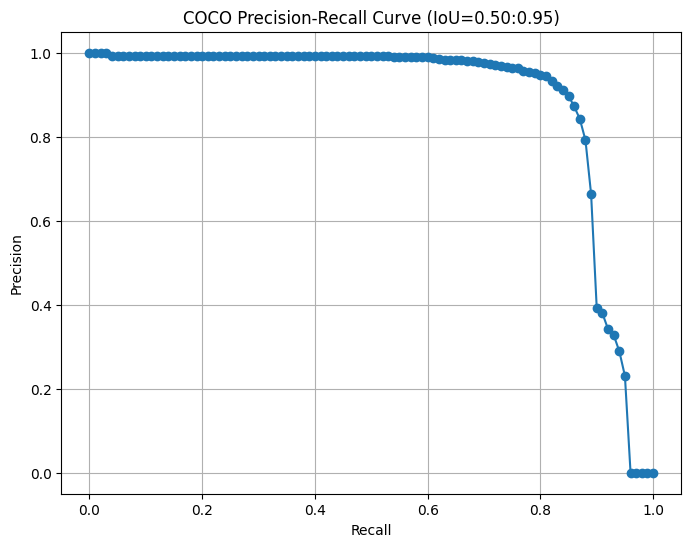


Epoch 5/20 | Time: 172.37s | Train Loss: 0.1908
  Global mAP@[.5:.95]: 0.6034
  Global Recall@100 : 0.6674
  🔥 New best model saved with mAP: 0.6034
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.205
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.375
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.65

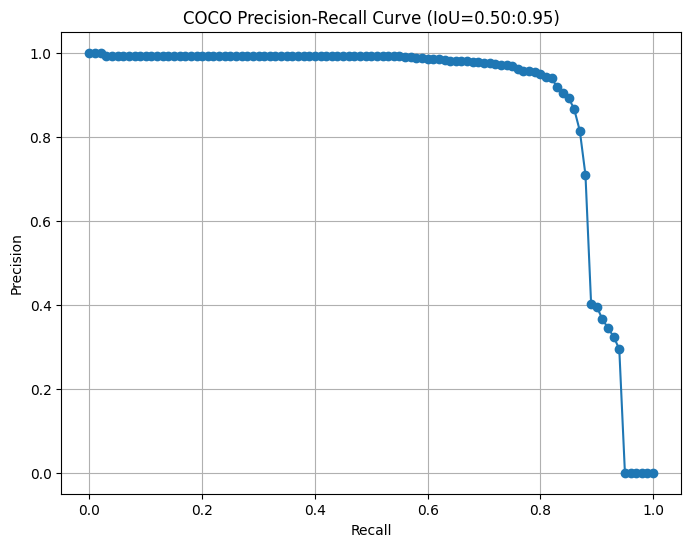


Epoch 6/20 | Time: 171.89s | Train Loss: 0.1826
  Global mAP@[.5:.95]: 0.5964
  Global Recall@100 : 0.6611
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.598
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.647
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.384
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.655
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.376
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.9

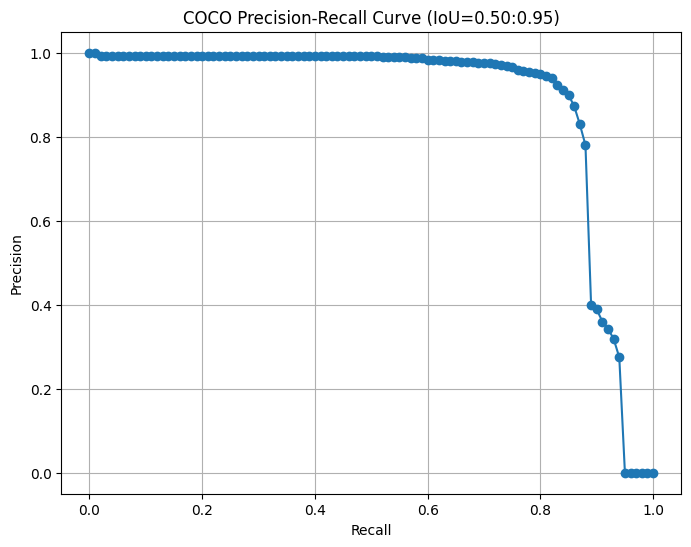


Epoch 7/20 | Time: 170.82s | Train Loss: 0.1757
  Global mAP@[.5:.95]: 0.5978
  Global Recall@100 : 0.6621
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.651
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.655
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.9

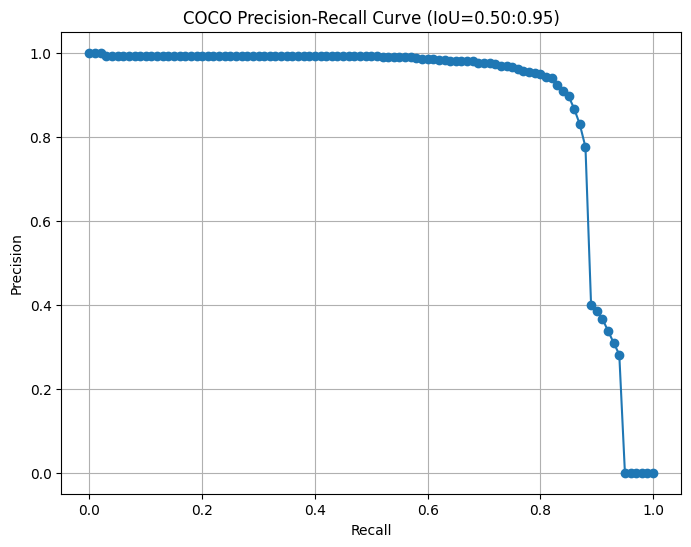


Epoch 8/20 | Time: 174.94s | Train Loss: 0.1742
  Global mAP@[.5:.95]: 0.5986
  Global Recall@100 : 0.6630
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.883
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.381
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.9

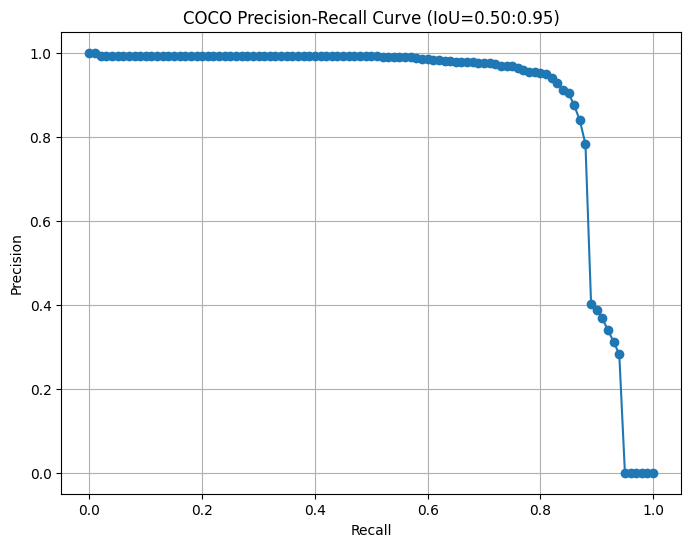


Epoch 9/20 | Time: 170.15s | Train Loss: 0.1736
  Global mAP@[.5:.95]: 0.5995
  Global Recall@100 : 0.6637
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.383
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.9

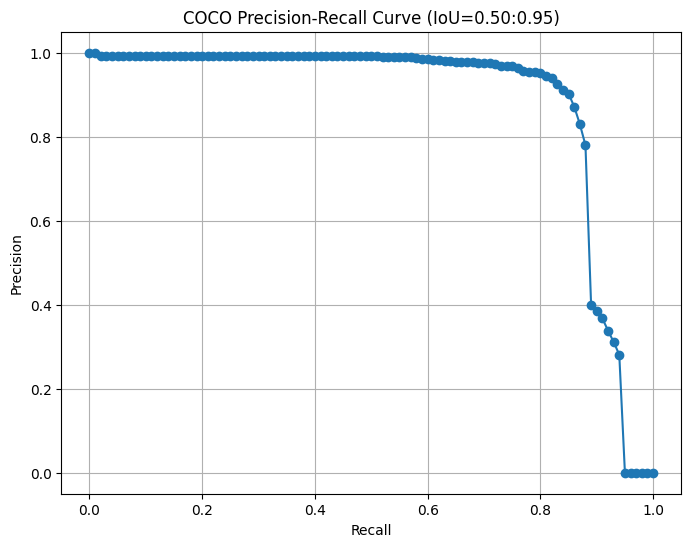


Epoch 10/20 | Time: 175.86s | Train Loss: 0.1729
  Global mAP@[.5:.95]: 0.5999
  Global Recall@100 : 0.6636
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.599
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.382
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.377
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.

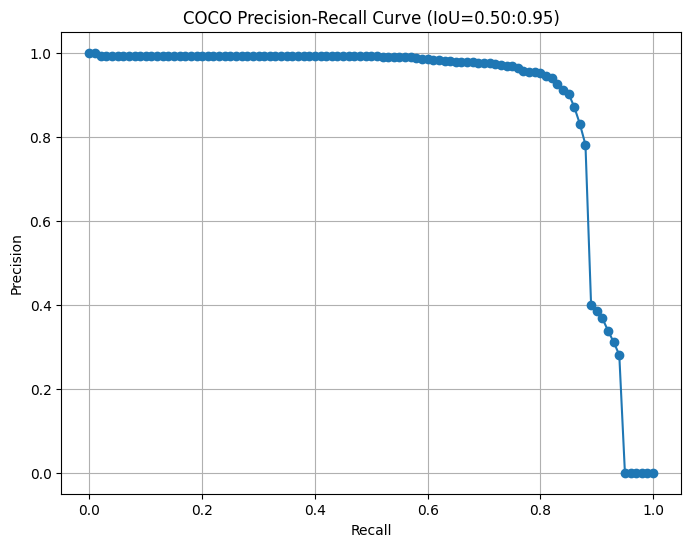


Epoch 11/20 | Time: 170.66s | Train Loss: 0.1733
  Global mAP@[.5:.95]: 0.5995
  Global Recall@100 : 0.6638
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.

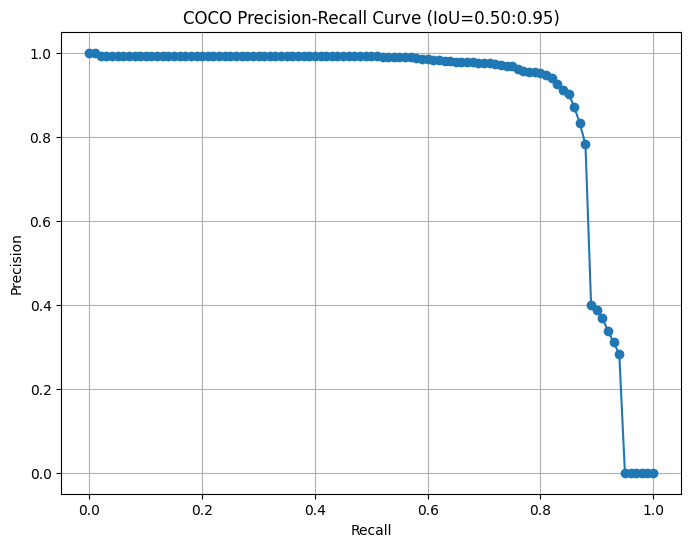


Epoch 12/20 | Time: 169.45s | Train Loss: 0.1726
  Global mAP@[.5:.95]: 0.6001
  Global Recall@100 : 0.6644
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.659
 Average Recall     (AR) @[ IoU=0.50:0.

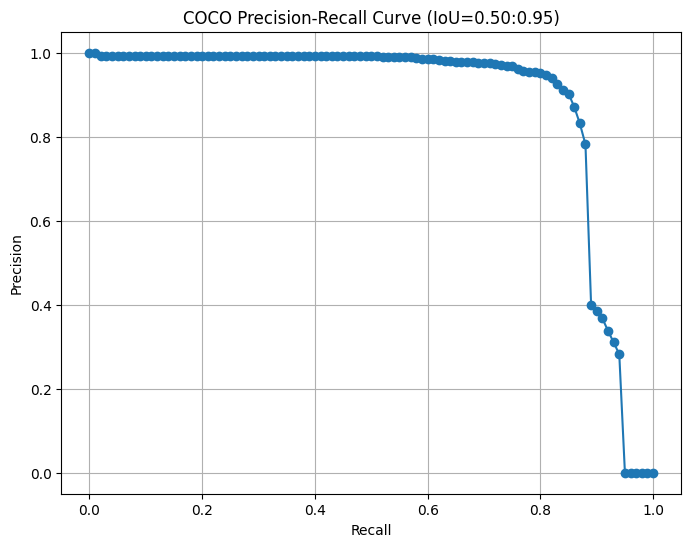


Epoch 13/20 | Time: 173.84s | Train Loss: 0.1731
  Global mAP@[.5:.95]: 0.6003
  Global Recall@100 : 0.6644
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.

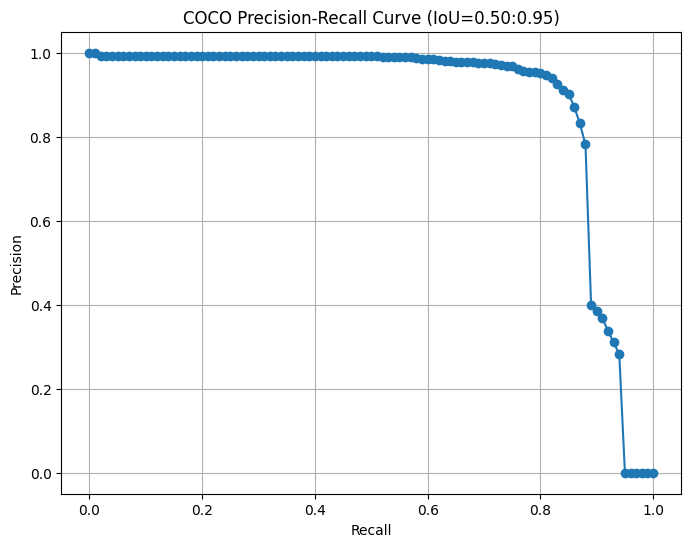


Epoch 14/20 | Time: 173.26s | Train Loss: 0.1730
  Global mAP@[.5:.95]: 0.6000
  Global Recall@100 : 0.6643
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.

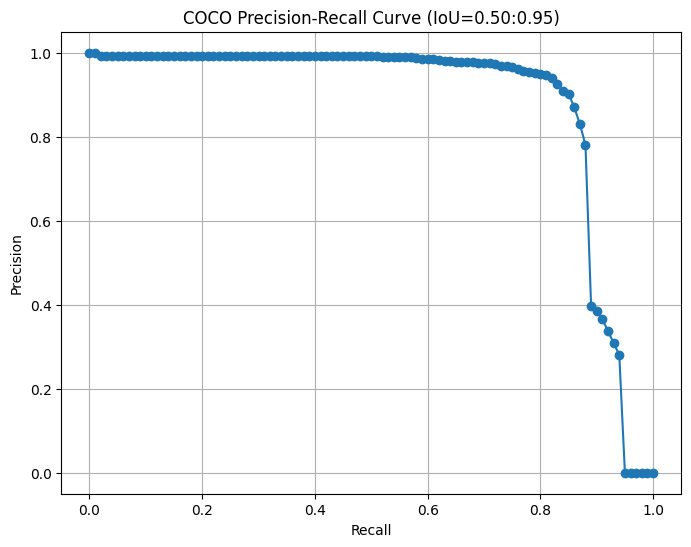


Epoch 15/20 | Time: 174.00s | Train Loss: 0.1722
  Global mAP@[.5:.95]: 0.6000
  Global Recall@100 : 0.6642
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.

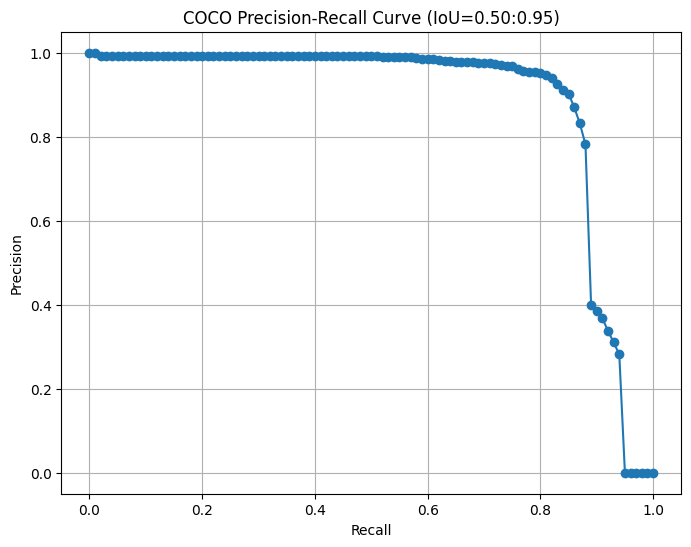


Epoch 16/20 | Time: 176.48s | Train Loss: 0.1728
  Global mAP@[.5:.95]: 0.6000
  Global Recall@100 : 0.6643
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.657
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.

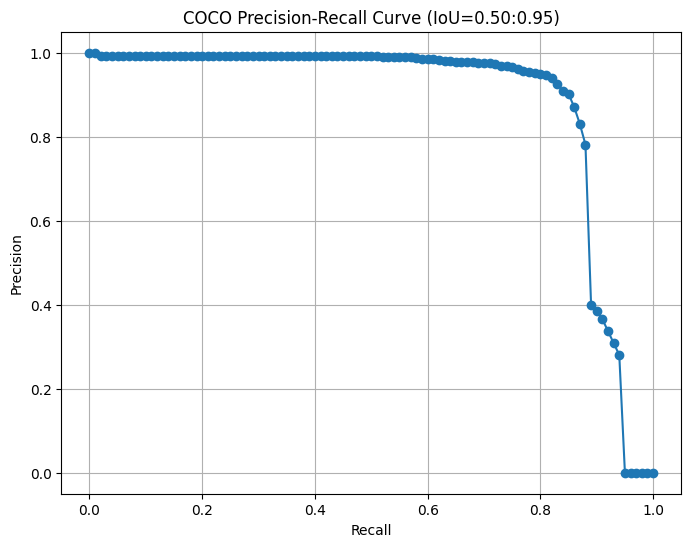


Epoch 17/20 | Time: 177.12s | Train Loss: 0.1724
  Global mAP@[.5:.95]: 0.6002
  Global Recall@100 : 0.6643
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.33s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.

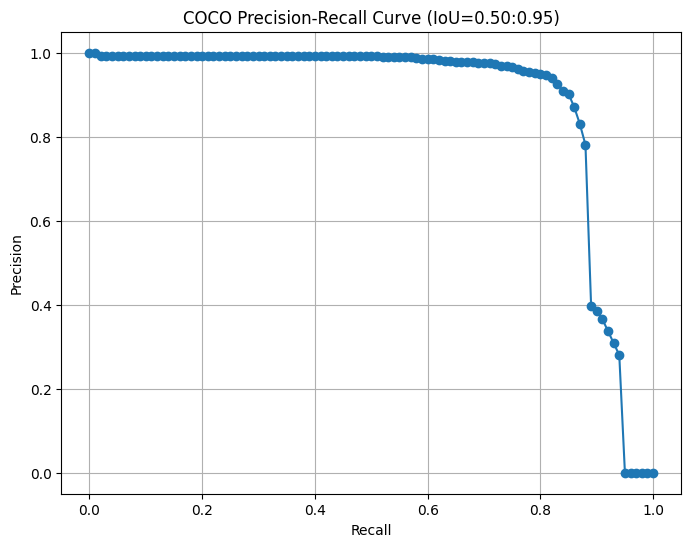


Epoch 18/20 | Time: 177.92s | Train Loss: 0.1730
  Global mAP@[.5:.95]: 0.6000
  Global Recall@100 : 0.6643
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.

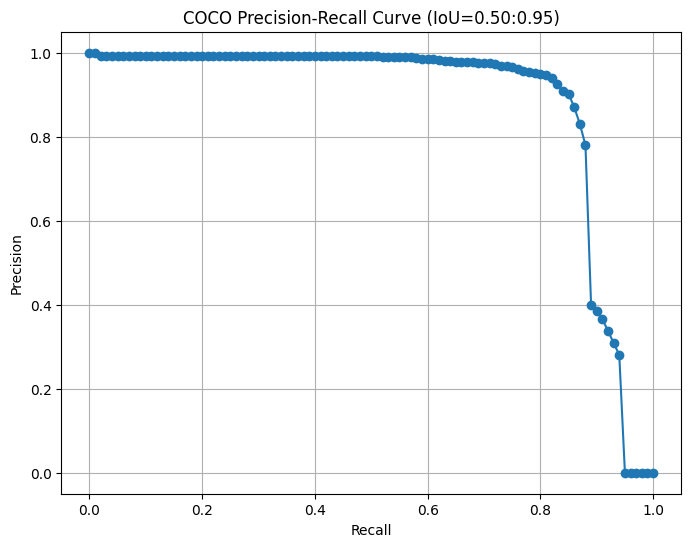


Epoch 19/20 | Time: 172.43s | Train Loss: 0.1729
  Global mAP@[.5:.95]: 0.6002
  Global Recall@100 : 0.6643
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.34s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.600
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.882
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.652
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.385
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.656
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.378
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.

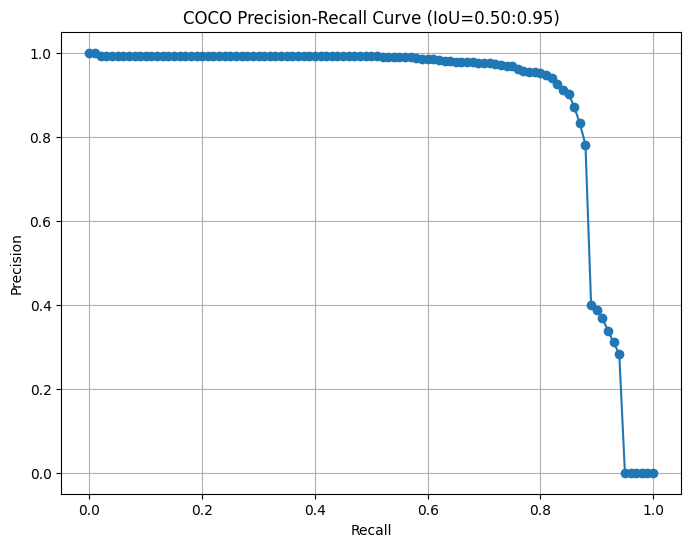


Epoch 20/20 | Time: 174.14s | Train Loss: 0.1728
  Global mAP@[.5:.95]: 0.6003
  Global Recall@100 : 0.6643
Training completed!


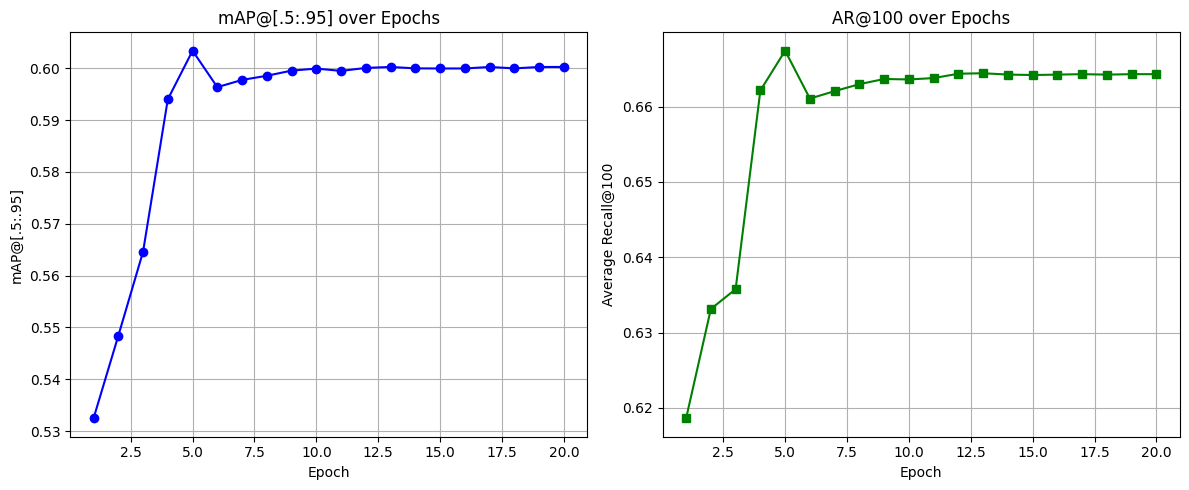

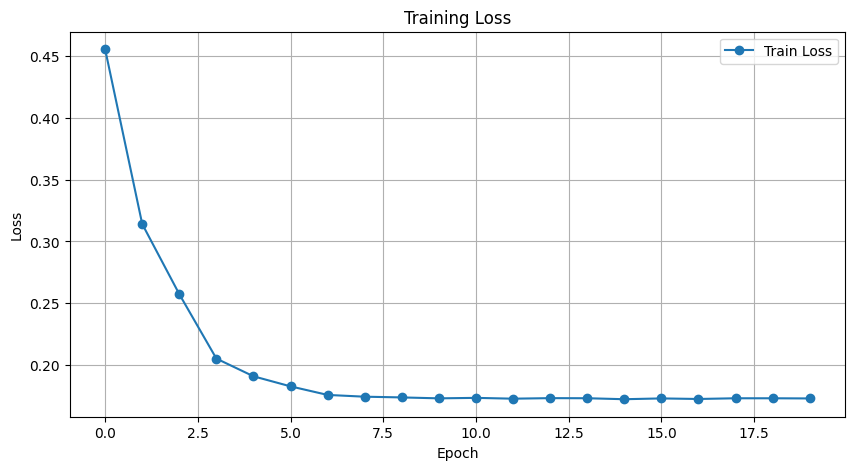

In [14]:
import torch
import time
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO
import copy
import json
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np

# --- 训练设置 ---
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


# --- COCO 全局评估函数 ---
def coco_evaluate(model, data_loader, device):
    model.eval()
    results = []
    image_ids = []
    cpu_device = torch.device("cpu")

    # 遍历验证集
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

        for target, output in zip(targets, outputs):
            image_id = target["image_id"].item()
            boxes = output["boxes"].tolist()
            scores = output["scores"].tolist()
            labels = output["labels"].tolist()

            for box, score, label in zip(boxes, scores, labels):
                x_min, y_min, x_max, y_max = box
                results.append({
                    "image_id": image_id,
                    "category_id": label,
                    "bbox": [x_min, y_min, x_max - x_min, y_max - y_min],
                    "score": score
                })
            image_ids.append(image_id)

    # 保存预测结果并进行 COCO 评估
    with tempfile.TemporaryDirectory() as tmpdirname:
        res_file = os.path.join(tmpdirname, "results.json")
        with open(res_file, "w") as f:
            json.dump(results, f, indent=4)

        coco_gt = data_loader.dataset.coco  # 使用验证集中的 COCO 对象
        coco_dt = coco_gt.loadRes(res_file)

        coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
        coco_eval.params.imgIds = list(set(image_ids))
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()

        # 获取全局指标
        stats = coco_eval.stats
        metrics = {
            "mAP@[.5:.95]": stats[0],
            "Recall@100": stats[8]  # AR@100
        }

        # 可视化 COCO Precision Matrix
        plot_precision_matrix(coco_eval)

    return metrics


# --- 可视化 Precision Matrix 函数 ---
def plot_precision_matrix(coco_eval):
    precisions = coco_eval.eval['precision']
    # precision: [TxRxKxAxM]，我们只取 IoU=0.50:0.95 的所有类、所有 area、maxDets=100 的平均
    precision = precisions[0, :, :, 0, 2]  # iou=0.5, area=all, maxDets=100

    # 取每一类的最大 recall 值的 precision 平均
    precision = np.mean(precision, axis=1)  # 每个 recall 下的平均
    recall = coco_eval.params.recThrs

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='o')
    plt.title("COCO Precision-Recall Curve (IoU=0.50:0.95)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()


# --- 训练循环 ---
num_epochs = 20
best_map = 0.0

# --- 存储每个 epoch 的评估指标 ---
epoch_maps = []
epoch_ars = []

# 在训练循环外定义存储列表
train_losses = []

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()
    running_loss = 0.0  # 重置每个 epoch 的累积 loss

    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()  # 累积 loss

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    # 计算平均 train loss
    avg_train_loss = running_loss / len(train_loader)
    # 在每个 epoch 结束后记录
    train_losses.append(avg_train_loss)


    # 验证并获取全局指标
    val_metrics = coco_evaluate(model, val_loader, device)

    # 打印验证结果
    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Train Loss: {avg_train_loss:.4f}")
    print(f"  Global mAP@[.5:.95]: {val_metrics['mAP@[.5:.95]']:.4f}")
    print(f"  Global Recall@100 : {val_metrics['Recall@100']:.4f}")

    # 保存最优模型
    if val_metrics["mAP@[.5:.95]"] > best_map:
        best_map = val_metrics["mAP@[.5:.95]"]
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"  🔥 New best model saved with mAP: {best_map:.4f}")

    # 记录每个 epoch 的指标
    epoch_maps.append(val_metrics["mAP@[.5:.95]"])
    epoch_ars.append(val_metrics["Recall@100"])


print("Training completed!")

# --- 可视化训练过程中每个 epoch 的 mAP 和 AR ---
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# mAP 曲线
plt.subplot(1, 2, 1)
plt.plot(epochs, epoch_maps, marker='o', color='blue')
plt.title("mAP@[.5:.95] over Epochs")
plt.xlabel("Epoch")
plt.ylabel("mAP@[.5:.95]")
plt.grid(True)

# AR 曲线
plt.subplot(1, 2, 2)
plt.plot(epochs, epoch_ars, marker='s', color='green')
plt.title("AR@100 over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Recall@100")
plt.grid(True)

plt.tight_layout()
plt.show()



# 训练结束后绘制曲线
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()


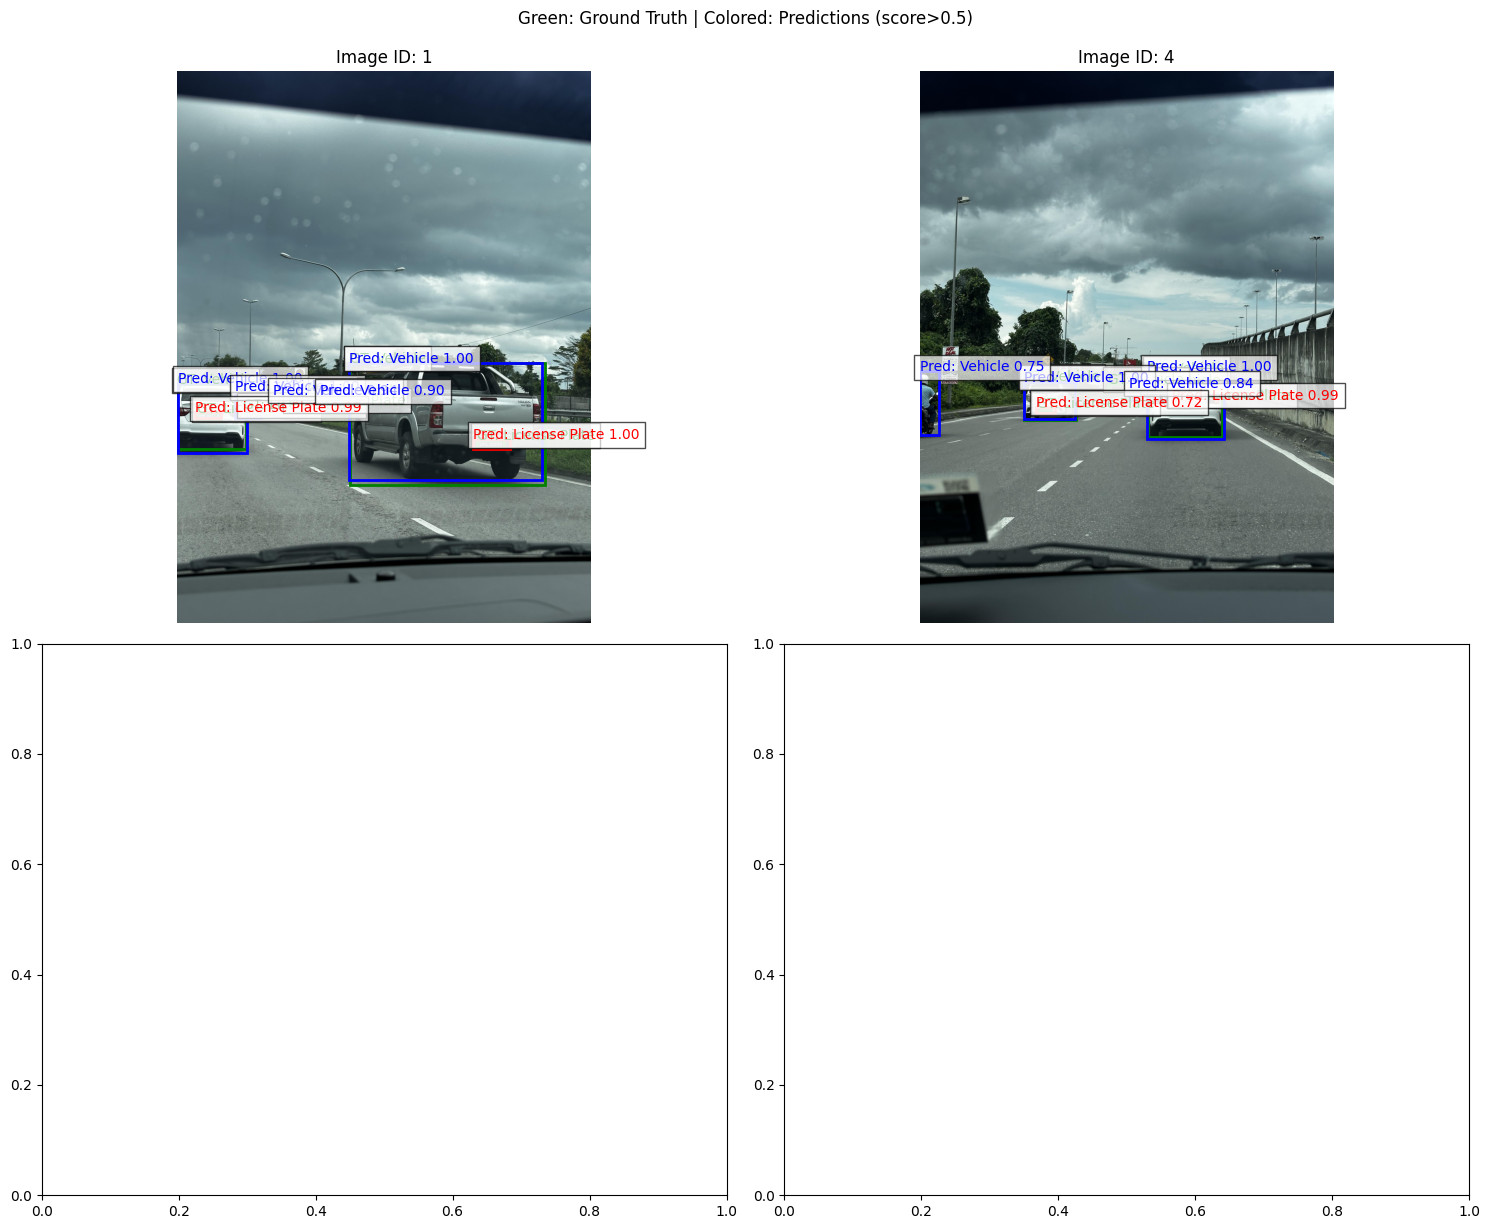

In [17]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import numpy as np
import torchvision

def visualize_predictions(model, data_loader, device, num_images=4):
    """可视化模型在验证集上的预测结果"""
    model.eval()

    # 获取一个batch的数据
    images, targets = next(iter(data_loader))
    images = [img.to(device) for img in images]

    # 获取模型预测
    with torch.no_grad():
        predictions = model(images)

    # 转换图像到CPU并反标准化
    images = [img.cpu() for img in images]
    predictions = [{k: v.cpu() for k, v in t.items()} for t in predictions]

    # 反标准化函数
    def denormalize(image):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return image * std + mean

    # 设置类别名称和颜色
    class_names = {1: 'License Plate', 2: 'Vehicle'}  # 根据你的类别ID修改
    colors = ['red', 'blue']  # 不同类别的框颜色

    # 显示图像
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, (image, target, prediction) in enumerate(zip(images, targets, predictions)):
        if idx >= num_images:
            break

        # 反标准化并转换为HWC格式
        image = denormalize(image)
        image = image.permute(1, 2, 0).numpy()
        image = np.clip(image, 0, 1)

        ax = axes[idx]
        ax.imshow(image)

        # 绘制真实框 (绿色)
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=2, edgecolor='green', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                x1, y1, f'GT: {class_names[label.item()]}',
                color='green', fontsize=10, bbox=dict(facecolor='white', alpha=0.7)
            )

        # 绘制预测框 (红色) - 只显示置信度>0.5的
        for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
            if score > 0.5:  # 只显示高置信度的预测
                x1, y1, x2, y2 = box
                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    linewidth=2, edgecolor=colors[label.item()-1], facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(
                    x1, y1, f'Pred: {class_names[label.item()]} {score:.2f}',
                    color=colors[label.item()-1], fontsize=10, bbox=dict(facecolor='white', alpha=0.7)
                )

        ax.set_title(f"Image ID: {target['image_id'].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle("Green: Ground Truth | Colored: Predictions (score>0.5)", y=1.02)
    plt.show()

# 使用训练好的模型进行可视化
visualize_predictions(model, val_loader, device)

evaluate on test dataset

In [48]:
# Load your best saved model (from epoch 5)
model = get_model(num_classes=3)  # Same architecture
model.load_state_dict(torch.load('best_model.pth'))
model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [49]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="FiU3mGWvliwkxuEHra5I")
project = rf.workspace("intelligent-systems-group-8-2025").project("vehicle-license-plate-detection-zasj3")
version = project.version(8)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...


In [50]:
#delete category 0

import json

# ===== Path to your original JSON =====
json_path = "/content/Vehicle-License-Plate-Detection-8/test/_annotations.coco.json"

# ===== Load original COCO data =====
with open(json_path, "r") as f:
    coco_data = json.load(f)

# ===== Filter out category with id = 0 =====
filtered_categories = [cat for cat in coco_data["categories"] if cat["id"] != 0]

# ===== Verify that annotations don’t use category_id 0 (they don’t) =====
filtered_annotations = [ann for ann in coco_data["annotations"] if ann["category_id"] != 0]

# ===== Update COCO data =====
coco_data["categories"] = filtered_categories
coco_data["annotations"] = filtered_annotations

# ===== Save cleaned JSON (overwrite original or create new file) =====
cleaned_json_path = json_path  # Overwrite original
# cleaned_json_path = json_path.replace(".json", "_cleaned.json")  # Save as new

with open(cleaned_json_path, "w") as f:
    json.dump(coco_data, f)

print(f"✅ Cleaned JSON saved to: {cleaned_json_path}")


✅ Cleaned JSON saved to: /content/Vehicle-License-Plate-Detection-8/test/_annotations.coco.json


In [51]:

import json

# ===== Path to your original JSON =====
json_path = "/content/Vehicle-License-Plate-Detection-8/test/_annotations.coco.json"

# ===== Load original COCO data =====
with open(json_path, "r") as f:
    coco_data = json.load(f)


def print_coco_summary(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    print(f"\n📂 File: {json_path}")
    print(f"🖼️ Total images: {len(data['images'])}")
    print(f"📝 Total annotations: {len(data['annotations'])}")
    print(f"🏷️ Total categories: {len(data['categories'])}\n")

    # Print all categories
    print("📚 Categories:")
    for cat in data['categories']:
        print(f"  ID: {cat['id']:2} | Name: {cat['name']} | Supercategory: {cat['supercategory']}")

    # Count how many annotations use each category_id
    ann_counts = Counter([ann["category_id"] for ann in data["annotations"]])
    print("\n📊 Annotation Counts by Category ID:")
    for cat in data['categories']:
        cat_id = cat["id"]
        print(f"  ID: {cat_id} ({cat['name']}): {ann_counts.get(cat_id, 0)} annotations")

    # Print first 3 images
    print("\n🖼️ Sample Images (first 3):")
    for img in data['images'][:3]:
        print(f"  ID: {img['id']}, File: {img['file_name']}, Size: {img['width']}x{img['height']}")

    # Print first 3 annotations
    print("\n🔍 Sample Annotations (first 3):")
    for ann in data['annotations'][:3]:
        print(f"  ID: {ann['id']}, ImageID: {ann['image_id']}, CatID: {ann['category_id']}, BBox: {ann['bbox']}, Area: {ann['area']}, Crowd: {ann['iscrowd']}")

# Run on both train and val
print_coco_summary("/content/Vehicle-License-Plate-Detection-8/test/_annotations.coco.json")



📂 File: /content/Vehicle-License-Plate-Detection-8/test/_annotations.coco.json
🖼️ Total images: 253
📝 Total annotations: 1494
🏷️ Total categories: 2

📚 Categories:
  ID:  1 | Name: carplate | Supercategory: vehicles
  ID:  2 | Name: vehicle | Supercategory: vehicles

📊 Annotation Counts by Category ID:
  ID: 1 (carplate): 512 annotations
  ID: 2 (vehicle): 982 annotations

🖼️ Sample Images (first 3):
  ID: 0, File: SD1117P_png.rf.6b424cc6ab73c7a42fc3b2557f47913f.jpg, Size: 3354x1754
  ID: 1, File: IMG_6527_jpg.rf.56ee9f30b837dc6ba8bda11a9a6f5a21.jpg, Size: 1422x2727
  ID: 2, File: IMG_6489_jpg.rf.bf4aaf2d9c66029f2130d2fffb3f7f70.jpg, Size: 4032x3024

🔍 Sample Annotations (first 3):
  ID: 0, ImageID: 0, CatID: 2, BBox: [1603, 394, 1468.61, 1118.85], Area: 1643154.298, Crowd: 0
  ID: 1, ImageID: 0, CatID: 1, BBox: [2152, 1190, 520.62, 119.51], Area: 62219.296, Crowd: 0
  ID: 2, ImageID: 1, CatID: 2, BBox: [104, 10, 1289.97, 1484.11], Area: 1914457.377, Crowd: 0


In [55]:

test_dataset = CocoDataset(
    root="/content/Vehicle-License-Plate-Detection-8/test",
    ann_file="/content/Vehicle-License-Plate-Detection-8/test/_annotations.coco.json"
)


test_loader = DataLoader(
    test_dataset,  # 修正为test_dataset
    batch_size=2,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=2,
    pin_memory=True
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.06s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.526
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.779
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.199
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.485
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.634
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.278
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.580
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

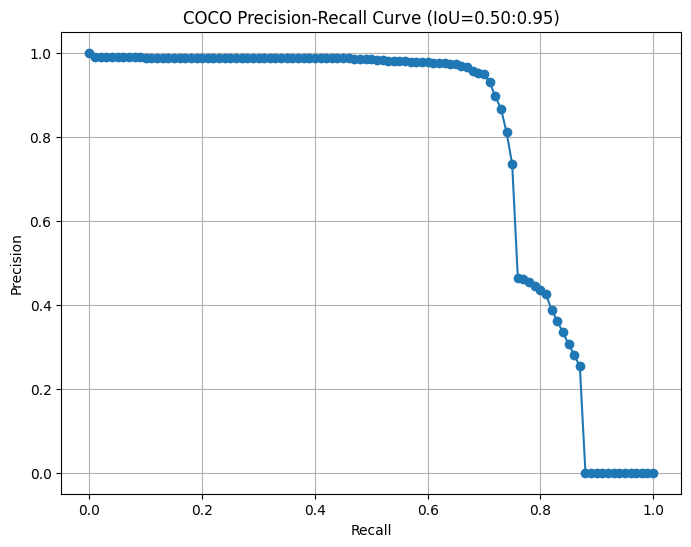


Evaluation on New Dataset:
mAP@[.5:.95]: 0.5255
Recall@100: 0.5798


In [56]:
# Evaluate on new dataset
new_metrics = coco_evaluate(model, test_loader, device)

print("\nEvaluation on New Dataset:")
print(f"mAP@[.5:.95]: {new_metrics['mAP@[.5:.95]']:.4f}")
print(f"Recall@100: {new_metrics['Recall@100']:.4f}")

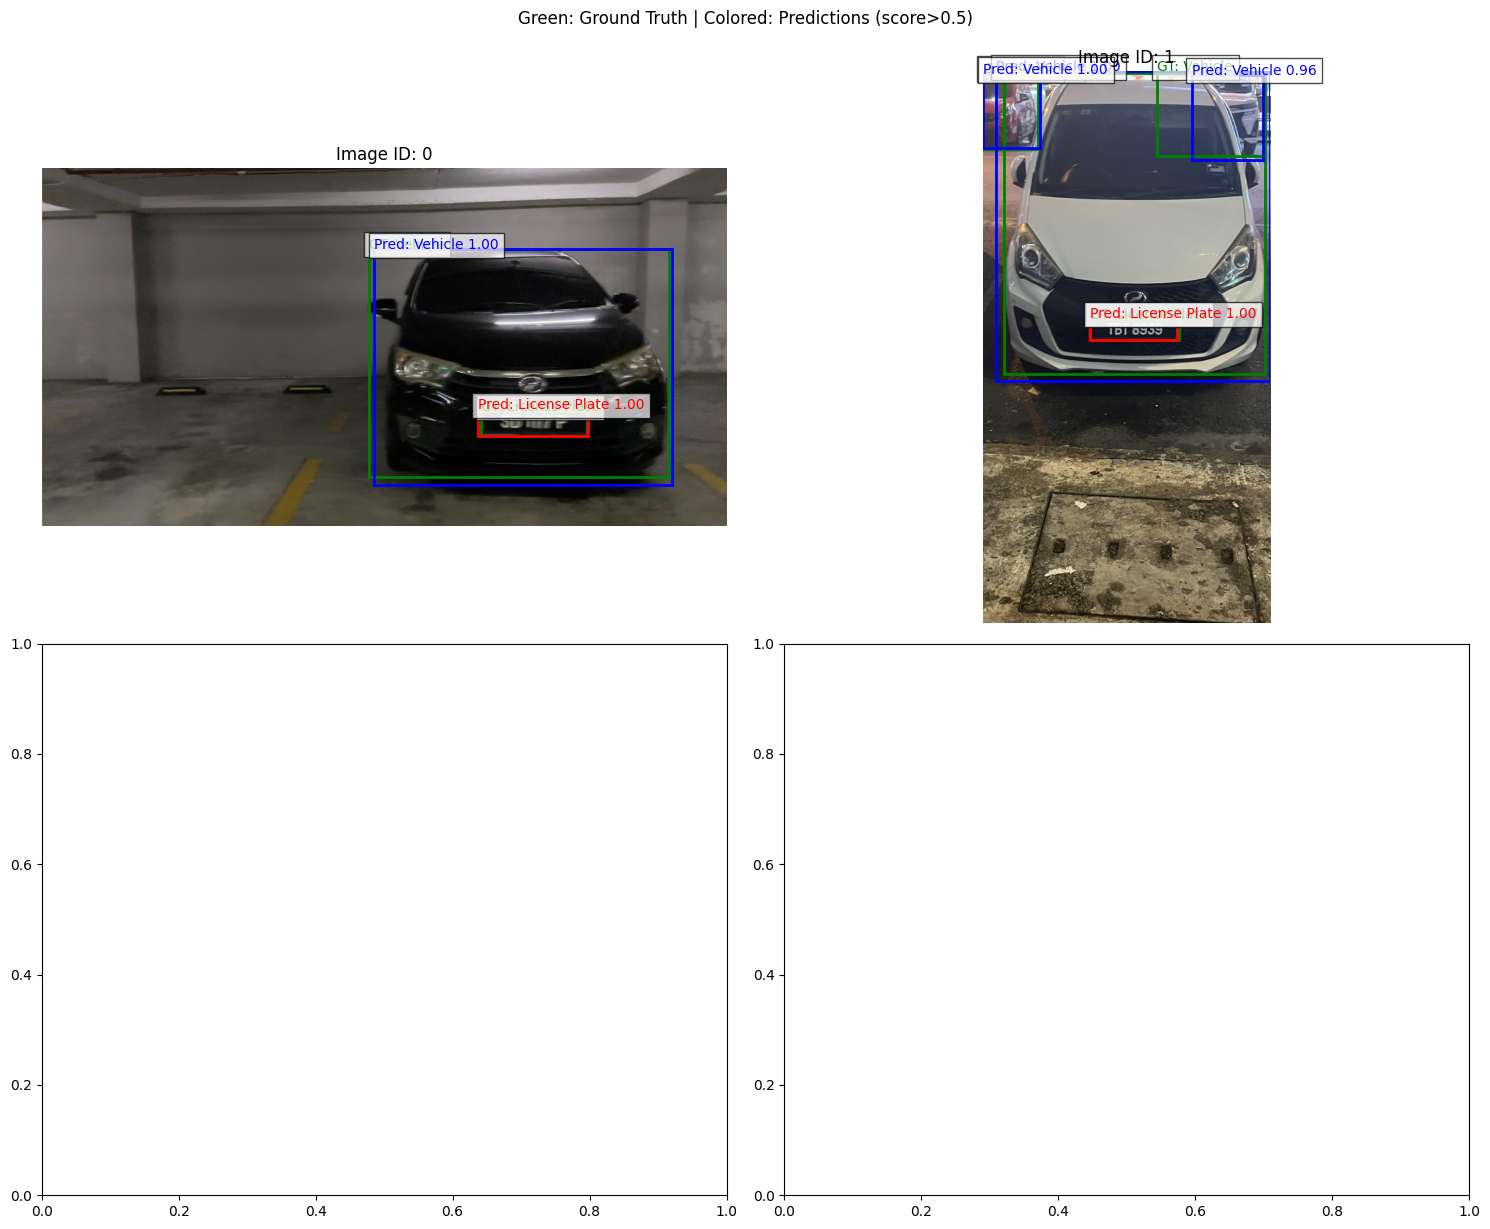

In [57]:
import matplotlib.patches as patches
from matplotlib import pyplot as plt
import numpy as np
import torchvision

def visualize_predictions(model, data_loader, device, num_images=4):
    """可视化模型在验证集上的预测结果"""
    model.eval()

    # 获取一个batch的数据
    images, targets = next(iter(data_loader))
    images = [img.to(device) for img in images]

    # 获取模型预测
    with torch.no_grad():
        predictions = model(images)

    # 转换图像到CPU并反标准化
    images = [img.cpu() for img in images]
    predictions = [{k: v.cpu() for k, v in t.items()} for t in predictions]

    # 反标准化函数
    def denormalize(image):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return image * std + mean

    # 设置类别名称和颜色
    class_names = {1: 'License Plate', 2: 'Vehicle'}  # 根据你的类别ID修改
    colors = ['red', 'blue']  # 不同类别的框颜色

    # 显示图像
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, (image, target, prediction) in enumerate(zip(images, targets, predictions)):
        if idx >= num_images:
            break

        # 反标准化并转换为HWC格式
        image = denormalize(image)
        image = image.permute(1, 2, 0).numpy()
        image = np.clip(image, 0, 1)

        ax = axes[idx]
        ax.imshow(image)

        # 绘制真实框 (绿色)
        for box, label in zip(target['boxes'], target['labels']):
            x1, y1, x2, y2 = box
            rect = patches.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=2, edgecolor='green', facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                x1, y1, f'GT: {class_names[label.item()]}',
                color='green', fontsize=10, bbox=dict(facecolor='white', alpha=0.7)
            )

        # 绘制预测框 (红色) - 只显示置信度>0.5的
        for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
            if score > 0.5:  # 只显示高置信度的预测
                x1, y1, x2, y2 = box
                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    linewidth=2, edgecolor=colors[label.item()-1], facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(
                    x1, y1, f'Pred: {class_names[label.item()]} {score:.2f}',
                    color=colors[label.item()-1], fontsize=10, bbox=dict(facecolor='white', alpha=0.7)
                )

        ax.set_title(f"Image ID: {target['image_id'].item()}")
        ax.axis('off')

    plt.tight_layout()
    plt.suptitle("Green: Ground Truth | Colored: Predictions (score>0.5)", y=1.02)
    plt.show()

# 使用训练好的模型进行可视化
visualize_predictions(model, test_loader, device)